# This is the submission Notebook of Team Sigmoid Freud 
by Qianjing, Danie, Jacob, Fan, Jan

## Download the data, import necessary packages and load the data into DataFrames

In [1]:
# Demonstration data used in this excercise is already preprocessed and split into
# training, validation, and test sets

# Use wget to download the data stored in csv format.
import itertools

# Define what files to download; download all of the preprocessed data
# Note that the data are already split into Train, Validation, and Test sets.
# The predictor data are denoted with 'X', the target by 'y'
data_download = {}
data_download["window_size"] = [5, 15]
data_download["data_type"] = ["train", "valid", "test"]
data_download["predictor_or_target"] = ["X", "y"]

# Prepare the combinations of the window sizes and the data types
keys, values = zip(*data_download.items())
data_download_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]
display('The kind of data to be downloaded:', data_download_combinations)

print("Downloading started...")
for data_download_param in data_download_combinations:
  file_to_download = "https://frankfurt-school-dataset.s3.eu-central-1.amazonaws.com/Sept2021/window_size_{0}_time_encoding_True/{1}_{2}_window_size_{0}_time_encoding_True.csv"\
                     .format(data_download_param["window_size"], data_download_param["predictor_or_target"], data_download_param["data_type"])

  # the actual downloading
  !wget "$file_to_download"

print("Downloading has finished")

'The kind of data to be downloaded:'

[{'data_type': 'train', 'predictor_or_target': 'X', 'window_size': 5},
 {'data_type': 'train', 'predictor_or_target': 'y', 'window_size': 5},
 {'data_type': 'valid', 'predictor_or_target': 'X', 'window_size': 5},
 {'data_type': 'valid', 'predictor_or_target': 'y', 'window_size': 5},
 {'data_type': 'test', 'predictor_or_target': 'X', 'window_size': 5},
 {'data_type': 'test', 'predictor_or_target': 'y', 'window_size': 5},
 {'data_type': 'train', 'predictor_or_target': 'X', 'window_size': 15},
 {'data_type': 'train', 'predictor_or_target': 'y', 'window_size': 15},
 {'data_type': 'valid', 'predictor_or_target': 'X', 'window_size': 15},
 {'data_type': 'valid', 'predictor_or_target': 'y', 'window_size': 15},
 {'data_type': 'test', 'predictor_or_target': 'X', 'window_size': 15},
 {'data_type': 'test', 'predictor_or_target': 'y', 'window_size': 15}]

--2021-11-05 13:40:40--  https://frankfurt-school-dataset.s3.eu-central-1.amazonaws.com/Sept2021/window_size_5_time_encoding_True/X_train_window_size_5_time_encoding_True.csv
Resolving frankfurt-school-dataset.s3.eu-central-1.amazonaws.com (frankfurt-school-dataset.s3.eu-central-1.amazonaws.com)... 52.219.140.4
Connecting to frankfurt-school-dataset.s3.eu-central-1.amazonaws.com (frankfurt-school-dataset.s3.eu-central-1.amazonaws.com)|52.219.140.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53997719 (51M) [text/csv]
Saving to: ‘X_train_window_size_5_time_encoding_True.csv’

X_train_window_size 100%[===================>]  51.50M  21.7MB/s    in 2.4s    

2021-11-05 13:40:43 (21.7 MB/s) - ‘X_train_window_size_5_time_encoding_True.csv’ saved [53997719/53997719]

--2021-11-05 13:40:43--  https://frankfurt-school-dataset.s3.eu-central-1.amazonaws.com/Sept2021/window_size_5_time_encoding_True/y_train_window_size_5_time_encoding_True.csv
Resolving frankfurt-schoo

In [2]:
pip install catboost

     |████████████████████████████████| 76.3 MB 24 kB/s 


In [3]:
#This imports all necessary packages for our tasks
import pandas as pd
import numpy as np

#Visualization imports
import matplotlib.pyplot as plt
import seaborn as sns

#Import necessary ml packages
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import GridSearchCV, cross_val_score
import xgboost as xgb
import catboost
from catboost import CatBoostRegressor 
import lightgbm as lgb

#Import necessary Deep Learning
import tensorflow as tf
import tensorflow.keras as k 
from tensorflow.keras.layers import *

import warnings
warnings.filterwarnings('ignore')

In [4]:
#Import the dataset with a sliding window of 5
X_train_window_size_5 = pd.read_csv('X_train_window_size_5_time_encoding_True.csv')
X_valid_window_size_5 = pd.read_csv('X_valid_window_size_5_time_encoding_True.csv')
X_test_window_size_5 = pd.read_csv('X_test_window_size_5_time_encoding_True.csv')
y_train_window_size_5 = pd.read_csv('y_train_window_size_5_time_encoding_True.csv')
y_valid_window_size_5 = pd.read_csv('y_valid_window_size_5_time_encoding_True.csv')
y_test_window_size_5 = pd.read_csv('y_test_window_size_5_time_encoding_True.csv')

# Exploratory Data Analysis (EDA)

## Helper functions for plotting

In [34]:
#First create our helper models to plot our analysis
def plot_subplots(dataframe: pd.DataFrame, title: str):
    """
    Draws one subplot for each of the columns in the DataFrame.
    """
    
    fig, axes = plt.subplots(nrows=len(dataframe.columns), figsize=(20,20))
    labels = list(dataframe.columns)

    for idx, row in enumerate(axes):
        y = dataframe.iloc[:, idx]
        row.plot(y, label=y.name)
        row.set_ylabel(labels[idx])

    fig.set_facecolor("grey")
    fig.suptitle(title, size=15, y=0.9)
    plt.show()

In [35]:
def plot_subplots_wrapper(
    dataframe: pd.DataFrame,
    title: str,
    labels: list = ["open", "high", "low", "close", "volume", "minutes"]
    ):
    """
    Calls the 'plot_subplots' function for each label provided in labels and selects columns that start with the label.
    """

    #df = dataframe.copy()
    for label in labels:
        print(f"Plots for {label}:")
        title = title + f" {label}"
        plot_subplots(dataframe.loc[:,dataframe.columns.str.startswith(label)], title)

### Get a basic understanding of the data

In [36]:
#Starting with our basic analysis for our data with a sliding winwow of 5
X_train_window_size_5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91512 entries, 0 to 91511
Data columns (total 41 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   total_hours             91512 non-null  float64
 1   dlvry_weekend           91512 non-null  float64
 2   dlvry_bank_holiday      91512 non-null  float64
 3   dlvry_day_sin           91512 non-null  float64
 4   dlvry_day_cos           91512 non-null  float64
 5   dlvry_weekday_sin       91512 non-null  float64
 6   dlvry_weekday_cos       91512 non-null  float64
 7   dlvry_hour_sin          91512 non-null  float64
 8   dlvry_hour_cos          91512 non-null  float64
 9   lasttrade_weekend       91512 non-null  float64
 10  lasttrade_bank_holiday  91512 non-null  float64
 11  lasttrade_day_sin       91512 non-null  float64
 12  lasttrade_day_cos       91512 non-null  float64
 13  lasttrade_weekday_sin   91512 non-null  float64
 14  lasttrade_weekday_cos   91512 non-null

In [37]:
#Lets renae our columns so we actually understand columns with name 1 - 23

def rename_time_series(df):
    labels = ["open", "high", "low", "close", "volume", "minutes"]
    new_cols = list(df.columns[:17])
    for i in range(4, 0, -1):
        for label in labels:
            new_cols.append(label+f"_{i}_{i-1}")

    df_original = df.copy()
    df.columns = new_cols

    return df

In [38]:
X_train_window_size_5 = rename_time_series(X_train_window_size_5)
X_valid_window_size_5 = rename_time_series(X_valid_window_size_5)
X_test_window_size_5 = rename_time_series(X_test_window_size_5)

In [39]:
X_train_window_size_5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91512 entries, 0 to 91511
Data columns (total 41 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   total_hours             91512 non-null  float64
 1   dlvry_weekend           91512 non-null  float64
 2   dlvry_bank_holiday      91512 non-null  float64
 3   dlvry_day_sin           91512 non-null  float64
 4   dlvry_day_cos           91512 non-null  float64
 5   dlvry_weekday_sin       91512 non-null  float64
 6   dlvry_weekday_cos       91512 non-null  float64
 7   dlvry_hour_sin          91512 non-null  float64
 8   dlvry_hour_cos          91512 non-null  float64
 9   lasttrade_weekend       91512 non-null  float64
 10  lasttrade_bank_holiday  91512 non-null  float64
 11  lasttrade_day_sin       91512 non-null  float64
 12  lasttrade_day_cos       91512 non-null  float64
 13  lasttrade_weekday_sin   91512 non-null  float64
 14  lasttrade_weekday_cos   91512 non-null

In [40]:
X_train_window_size_5.head(5)

,total_hours,dlvry_weekend,dlvry_bank_holiday,dlvry_day_sin,dlvry_day_cos,dlvry_weekday_sin,dlvry_weekday_cos,dlvry_hour_sin,dlvry_hour_cos,lasttrade_weekend,lasttrade_bank_holiday,lasttrade_day_sin,lasttrade_day_cos,lasttrade_weekday_sin,lasttrade_weekday_cos,lasttrade_hour_sin,lasttrade_hour_cos,open_4_3,high_4_3,low_4_3,close_4_3,volume_4_3,minutes_4_3,open_3_2,high_3_2,low_3_2,close_3_2,volume_3_2,minutes_3_2,open_2_1,high_2_1,low_2_1,close_2_1,volume_2_1,minutes_2_1,open_1_0,high_1_0,low_1_0,close_1_0,volume_1_0,minutes_1_0
0,10.001383,1.0,0.0,0.201299,0.97953,-0.781831,0.62349,-0.5,0.866025,1.0,0.0,0.201299,0.97953,-0.781831,0.62349,-0.707107,-7.071068e-01,0.548624,0.342375,0.483483,0.450294,0.285111,0.16,0.314494,0.486784,0.301933,0.333574,0.511595,0.16,0.367678,0.596980,0.518639,0.445045,0.511702,0.16,0.378254,0.289166,0.470863,0.302977,0.509702,0.16
1,10.001383,1.0,0.0,0.201299,0.97953,-0.781831,0.62349,-0.5,0.866025,1.0,0.0,0.201299,0.97953,-0.781831,0.62349,-0.866025,-5.000000e-01,0.481299,0.330252,0.445686,0.436614,0.286310,0.12,0.454300,0.502022,0.393267,0.399807,0.511702,0.12,0.359601,0.585893,0.482680,0.397880,0.509702,0.12,0.347688,0.289220,0.453237,0.292983,0.509118,0.12
2,10.001383,1.0,0.0,0.201299,0.97953,-0.781831,0.62349,-0.5,0.866025,1.0,0.0,0.201299,0.97953,-0.781831,0.62349,-0.965926,-2.588190e-01,0.587085,0.350137,0.518211,0.504933,0.286467,0.08,0.444320,0.492698,0.366000,0.345792,0.509702,0.08,0.323973,0.585933,0.465448,0.384756,0.509118,0.08,0.327095,0.276471,0.387500,0.292822,0.517617,0.08
3,10.001383,1.0,0.0,0.201299,0.97953,-0.781831,0.62349,-0.5,0.866025,1.0,0.0,0.201299,0.97953,-0.781831,0.62349,-1.000000,-1.836970e-16,0.579534,0.337970,0.496559,0.449216,0.283544,0.04,0.400298,0.492732,0.352933,0.330761,0.509118,0.04,0.299970,0.576436,0.401178,0.384545,0.517617,0.04,0.330916,0.281272,0.481115,0.309925,0.506423,0.04
4,10.001383,1.0,0.0,0.201299,0.97953,-0.781831,0.62349,-0.5,0.866025,1.0,0.0,0.201299,0.97953,-0.781831,0.62349,-0.965926,2.588190e-01,0.546224,0.338014,0.486183,0.433712,0.282690,0.00,0.370640,0.484745,0.304200,0.330520,0.517617,0.00,0.304423,0.580012,0.492703,0.407004,0.506423,0.00,0.345163,0.284365,0.449191,0.295602,0.510396,0.00


## This plots how many rows per contarct are and aggregates them

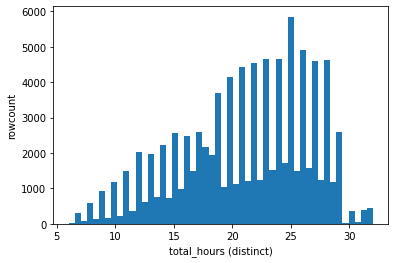

In [12]:
#This distribution show how many rows
X_train_window_size_5_grouped = X_train_window_size_5.groupby("total_hours").size().reset_index()
X_train_window_size_5_grouped.rename(columns={0: "rowcount"}, inplace=True)

plt.hist(X_train_window_size_5["total_hours"], label="rowcount", bins=50)
plt.xlabel("total_hours (distinct)")
plt.ylabel("rowcount")
plt.show()

## Candle Features 

Plots for open:


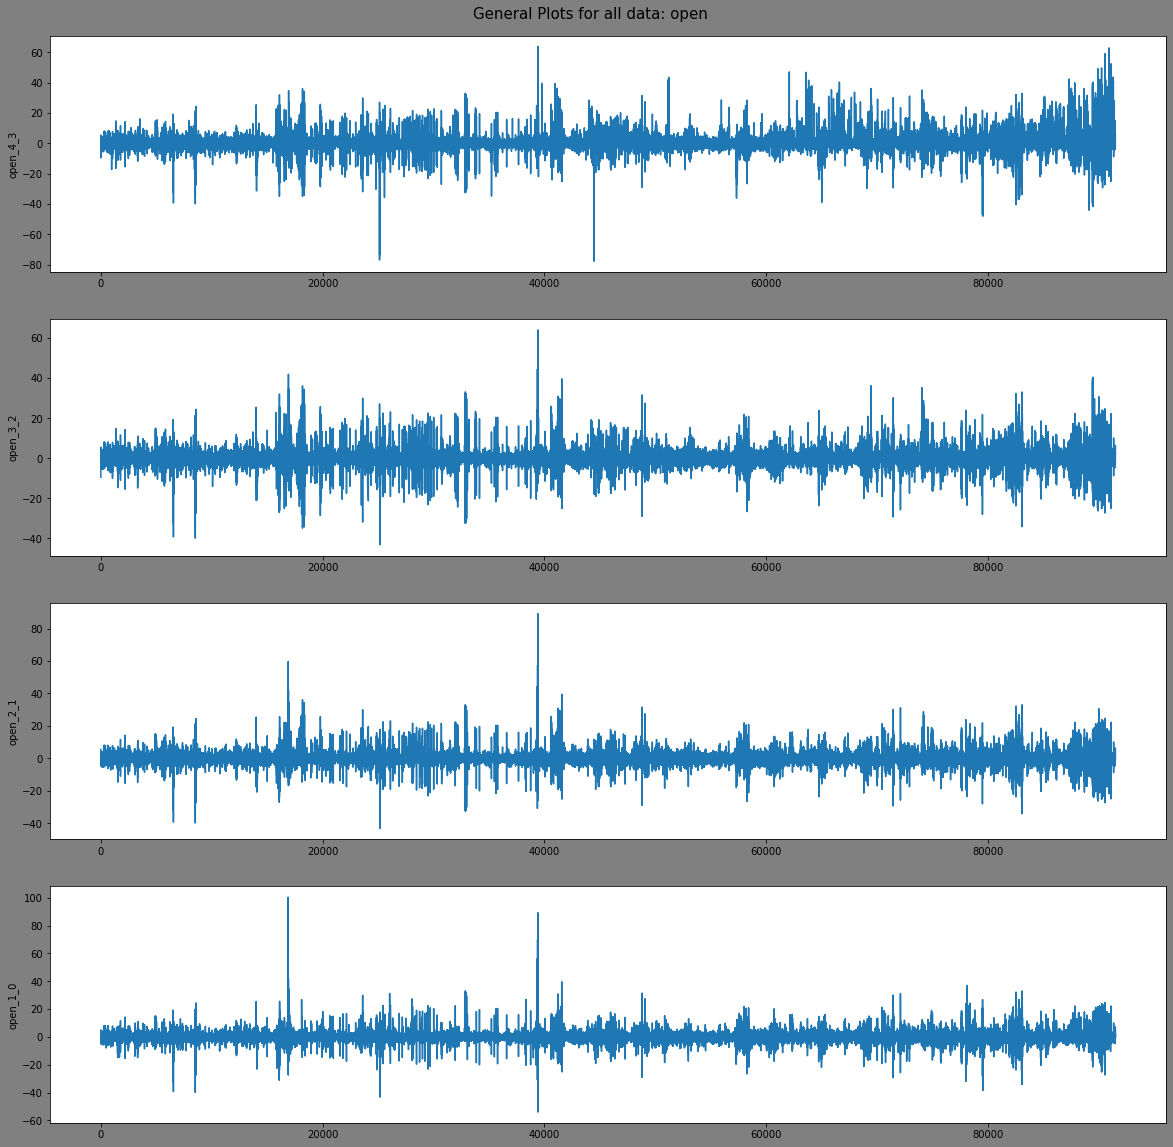

Plots for high:


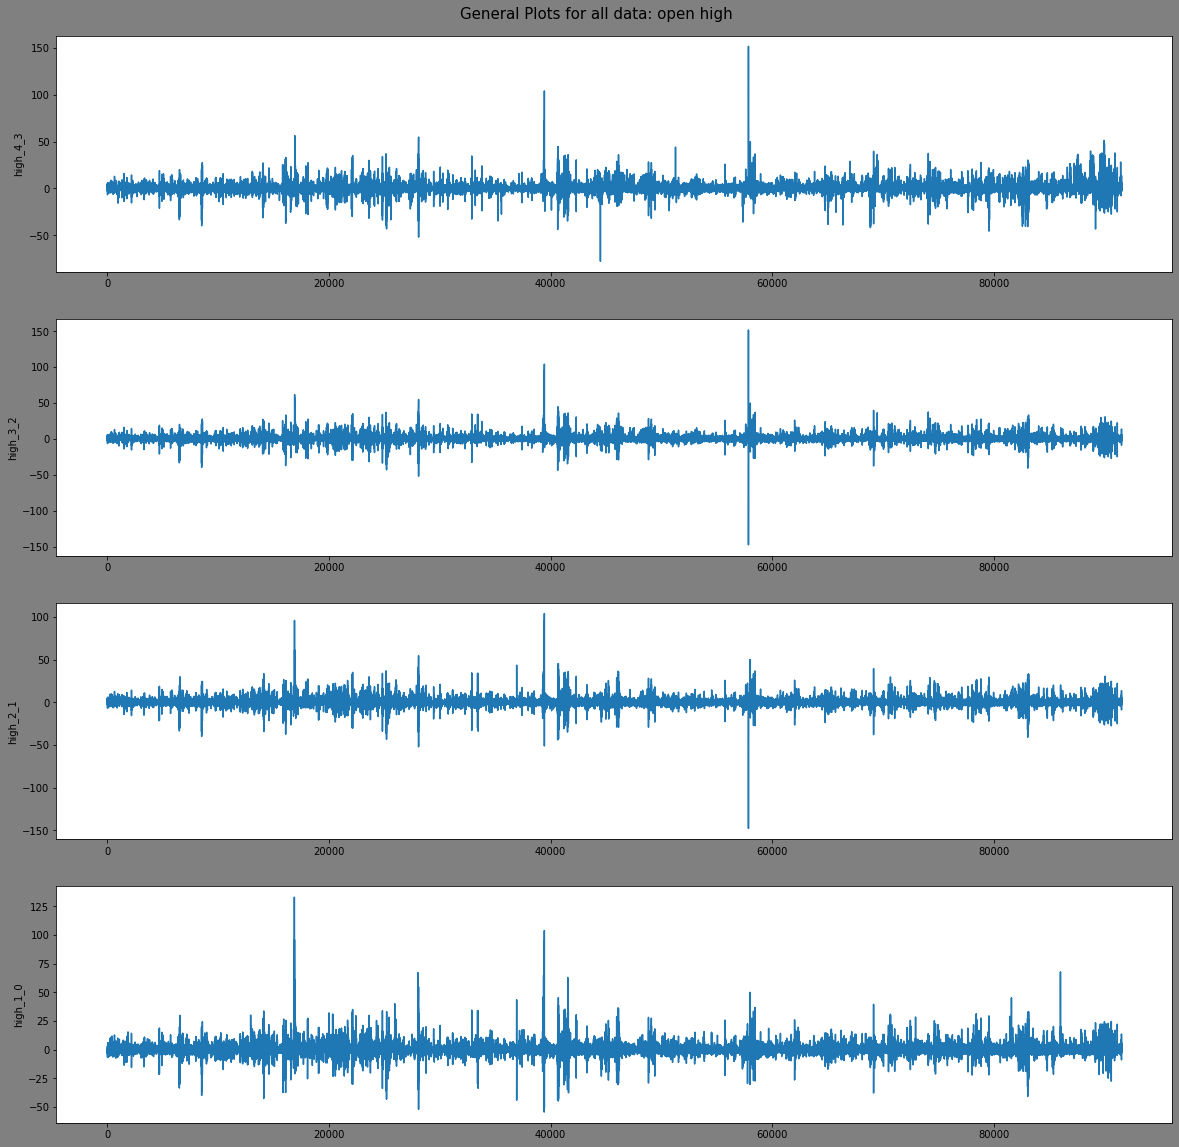

Plots for low:


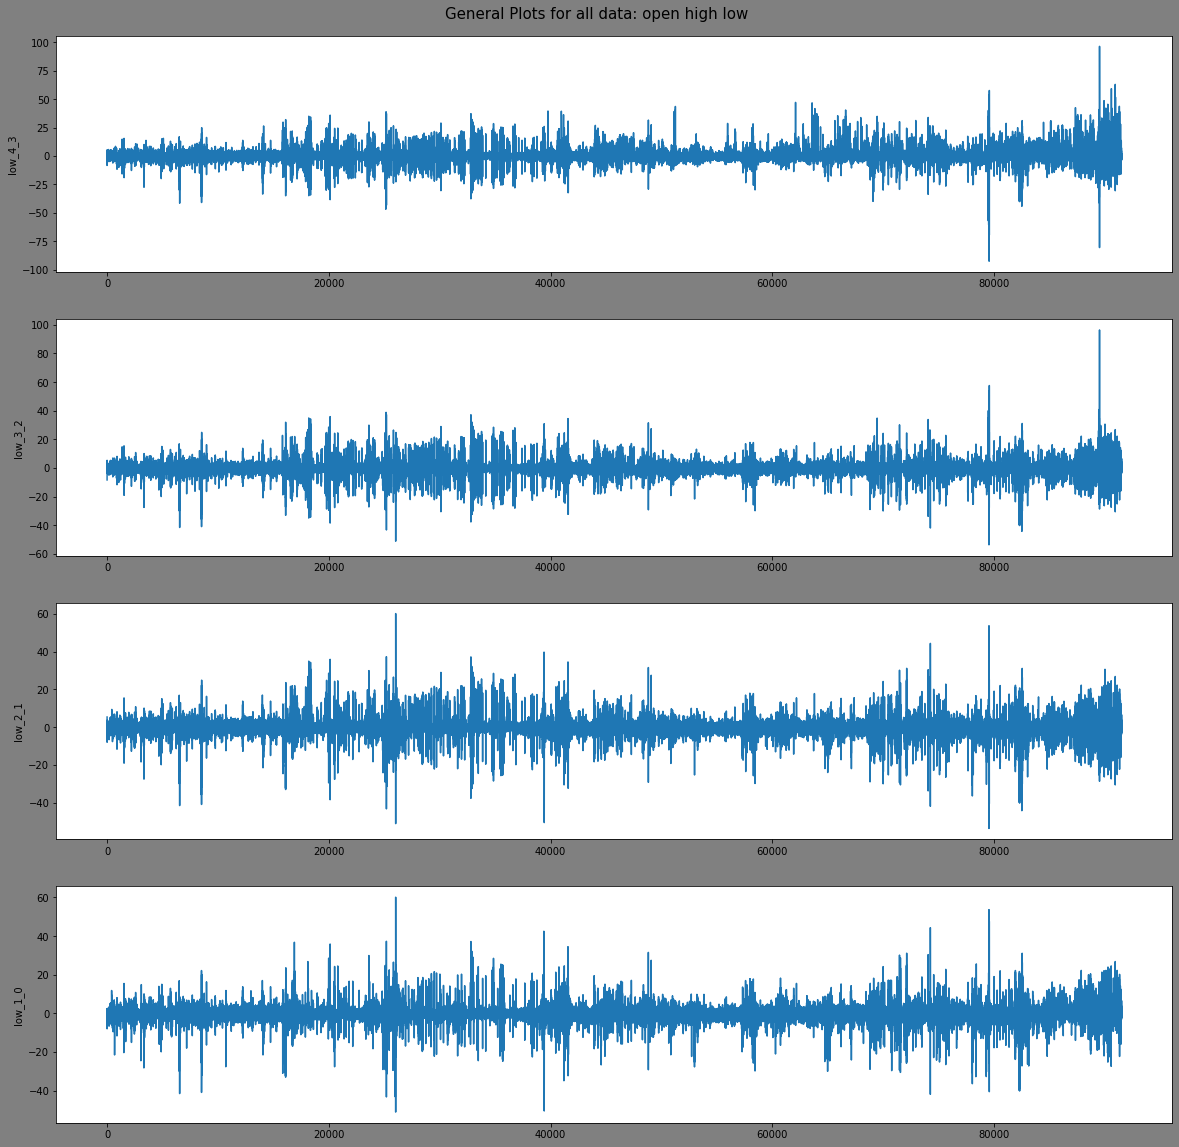

Plots for close:


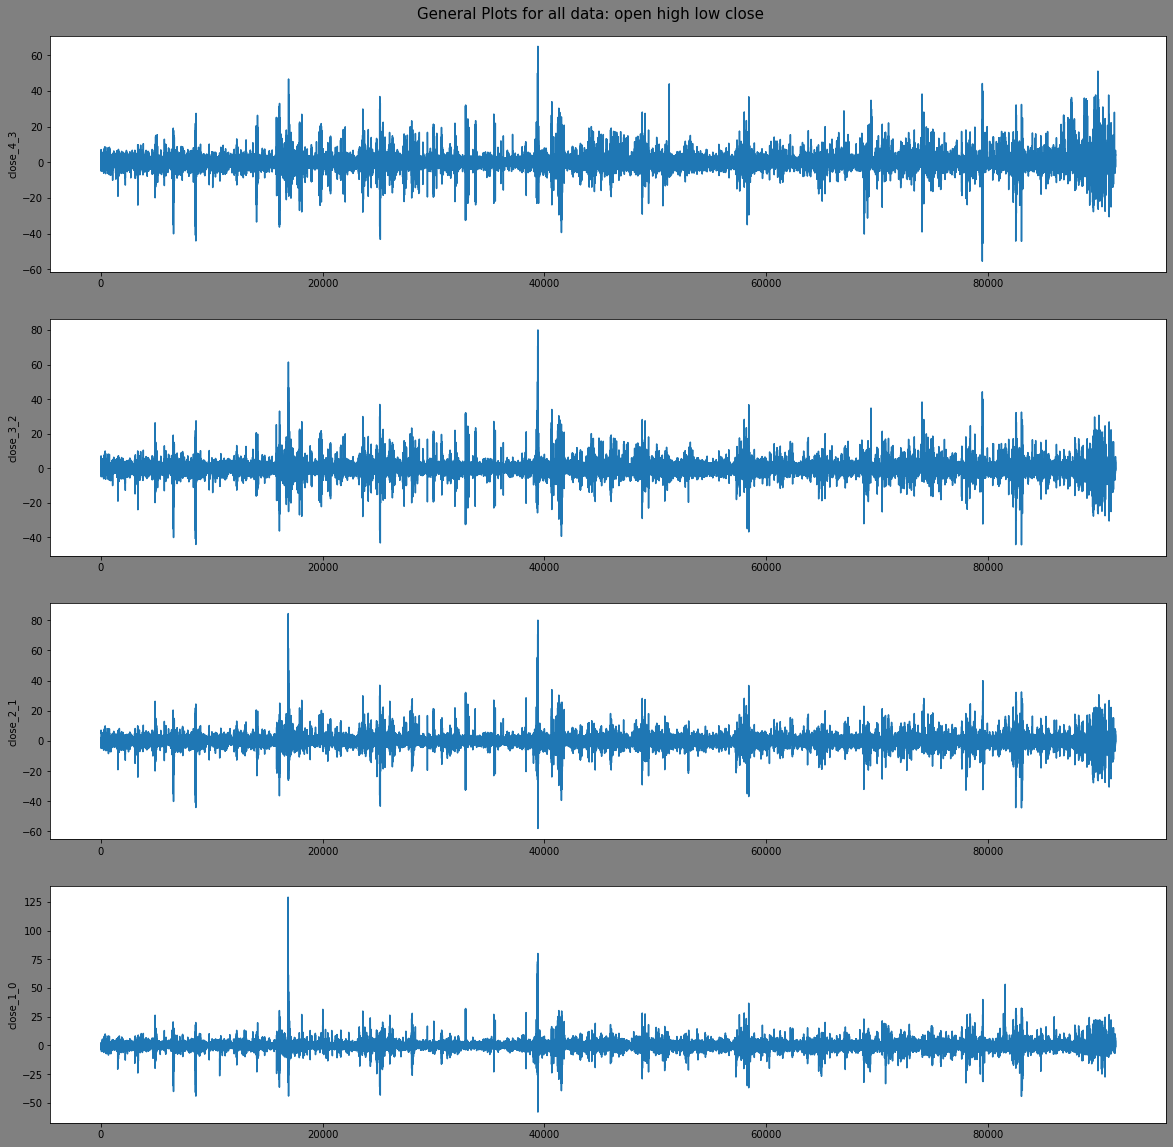

Plots for volume:


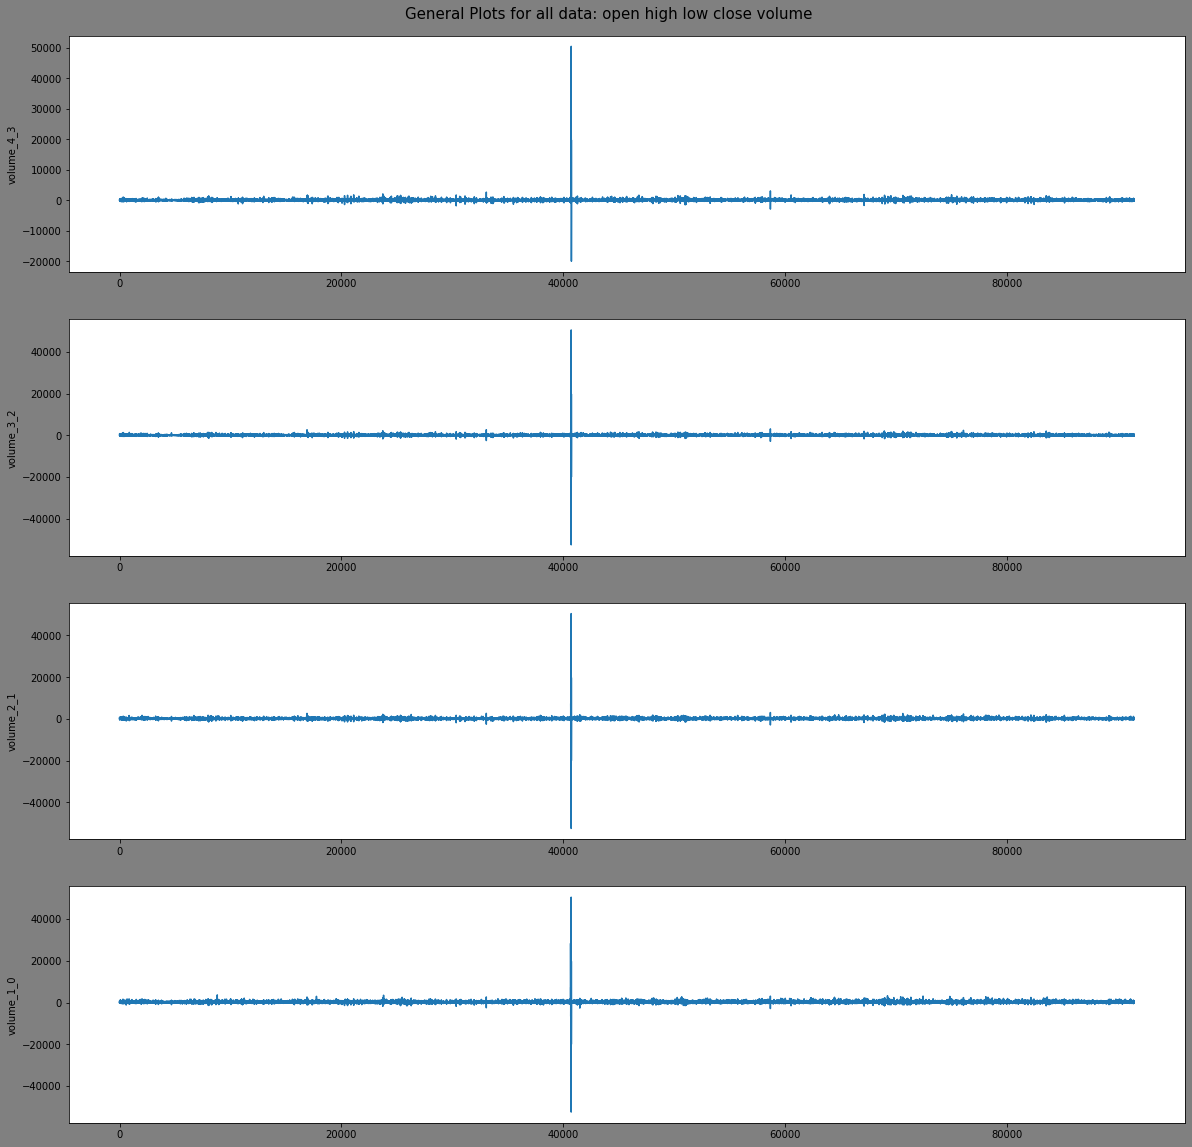

Plots for minutes:


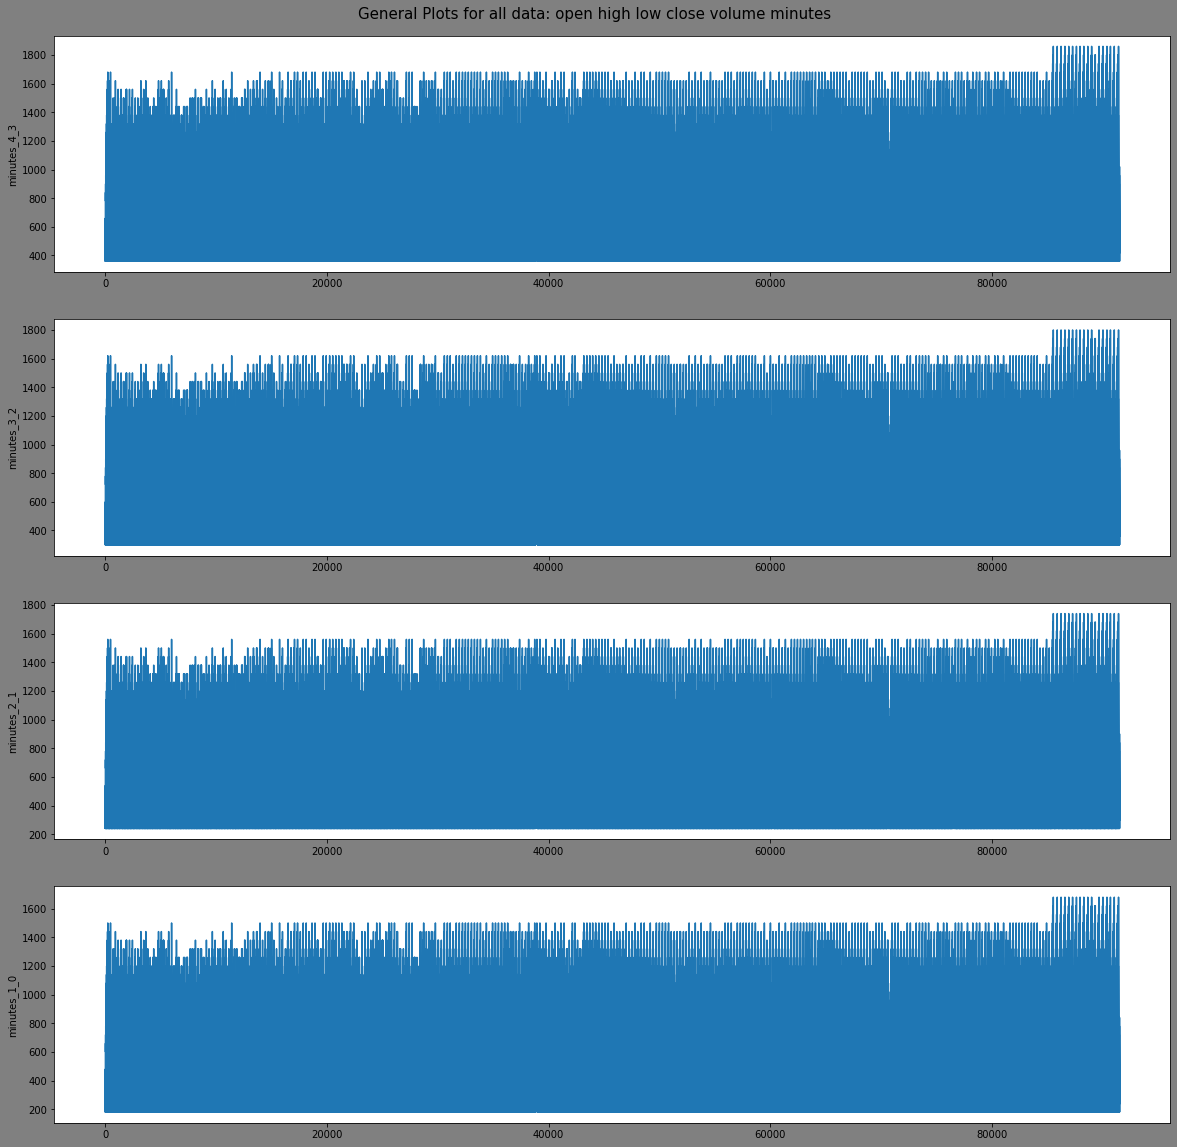

In [13]:
df_to_plot = X_train_window_size_5.copy()
title = "General Plots for all data:"
plot_subplots_wrapper(df_to_plot, title)

Plots for open:


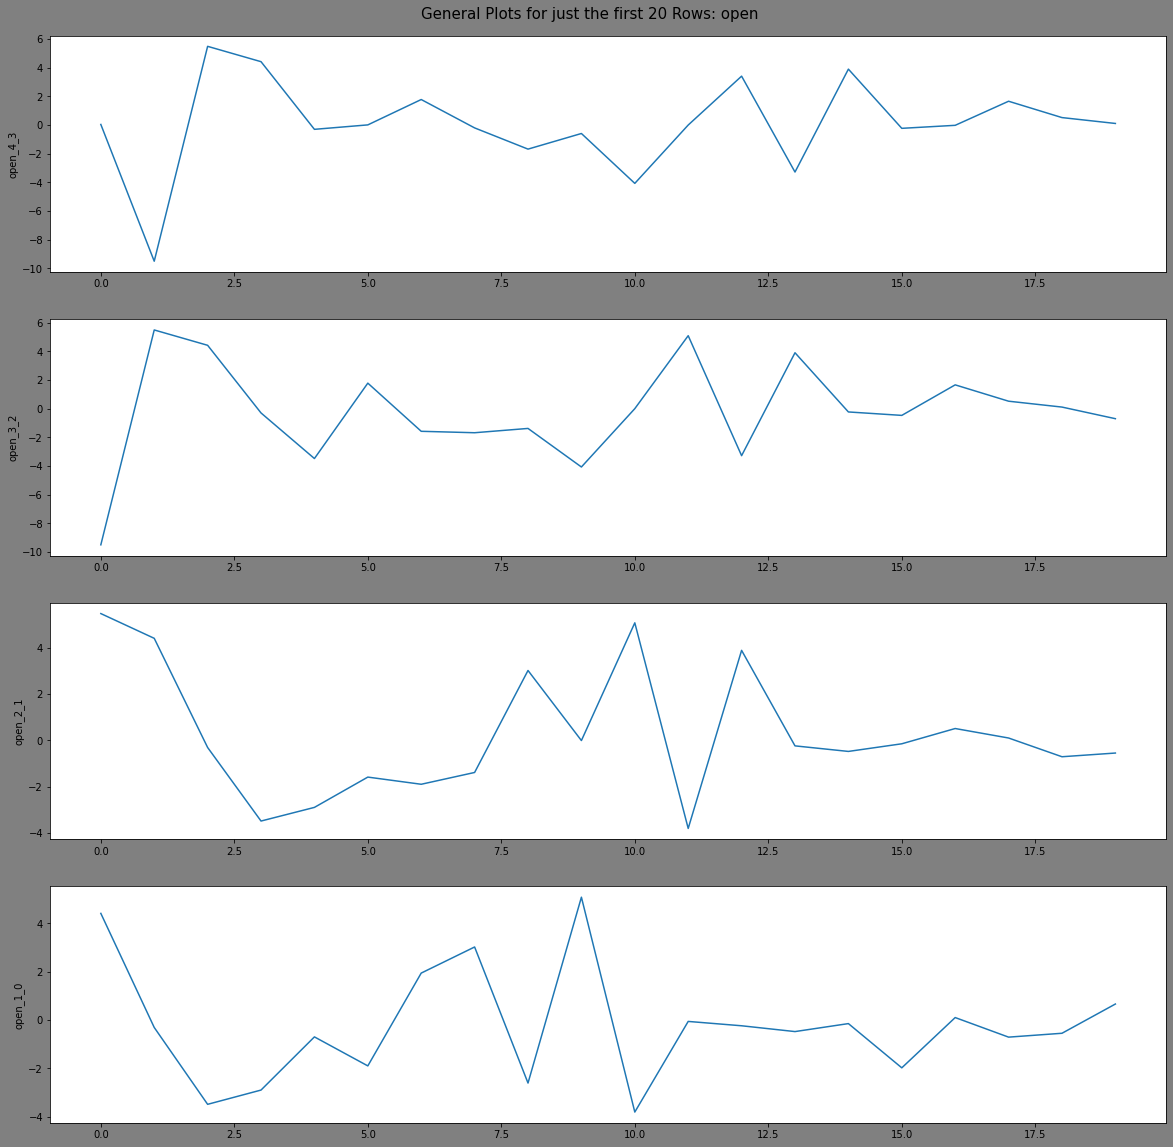

Plots for high:


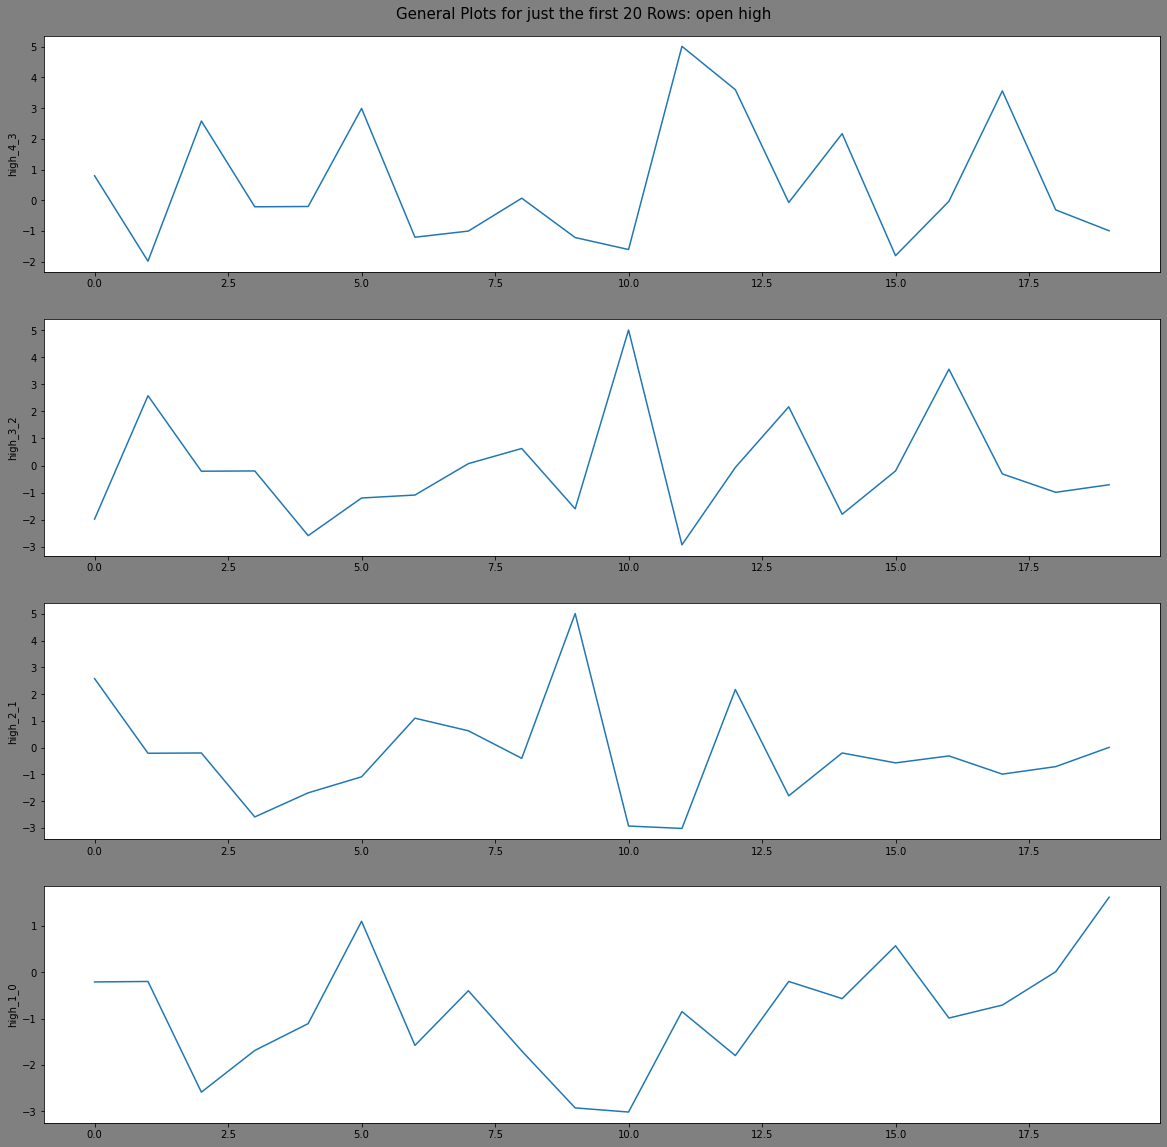

Plots for low:


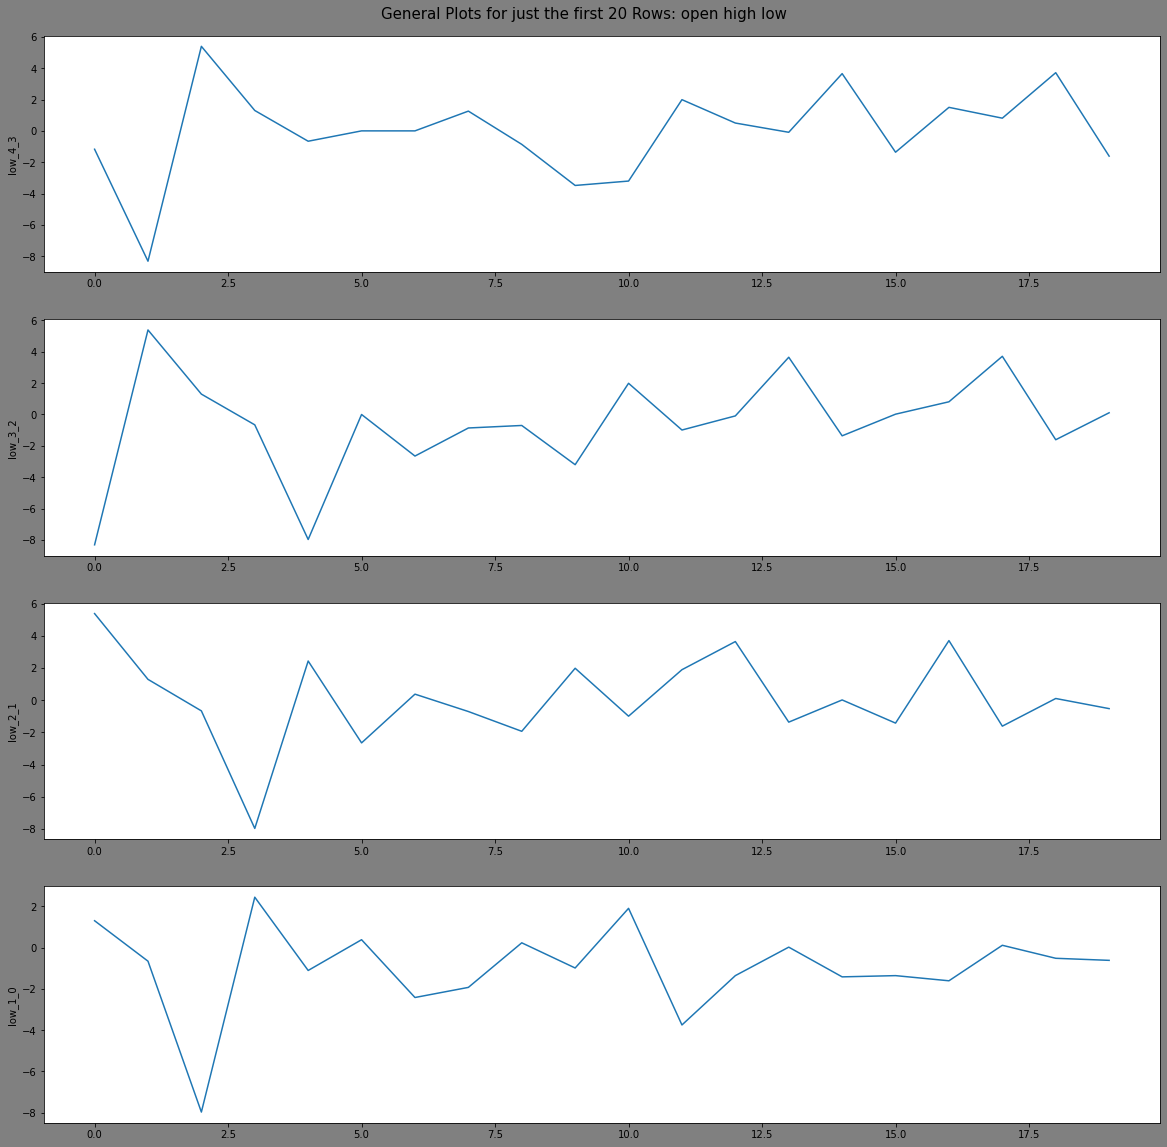

Plots for close:


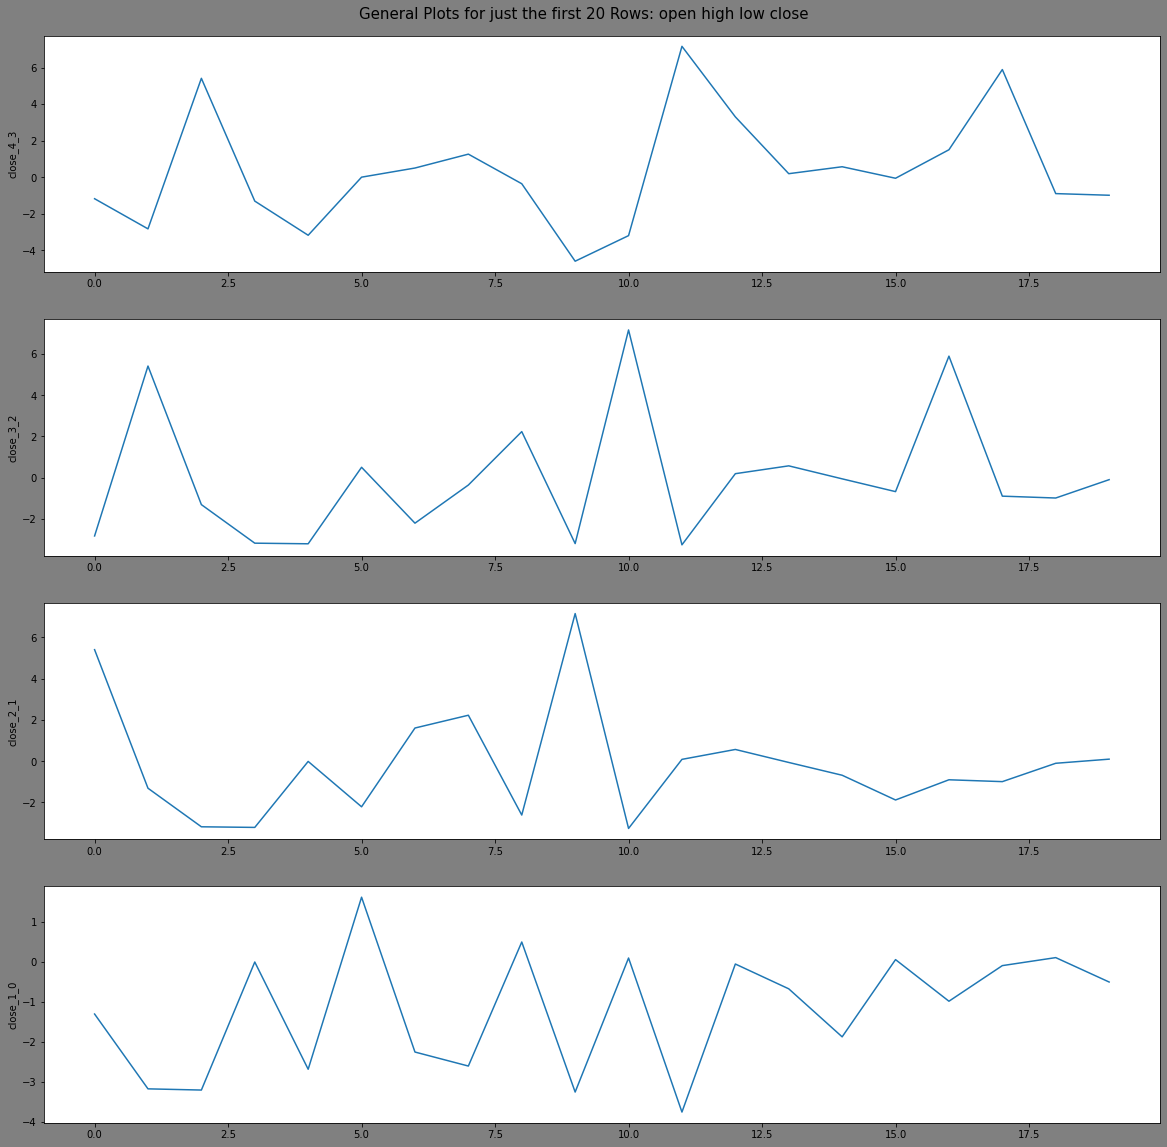

Plots for volume:


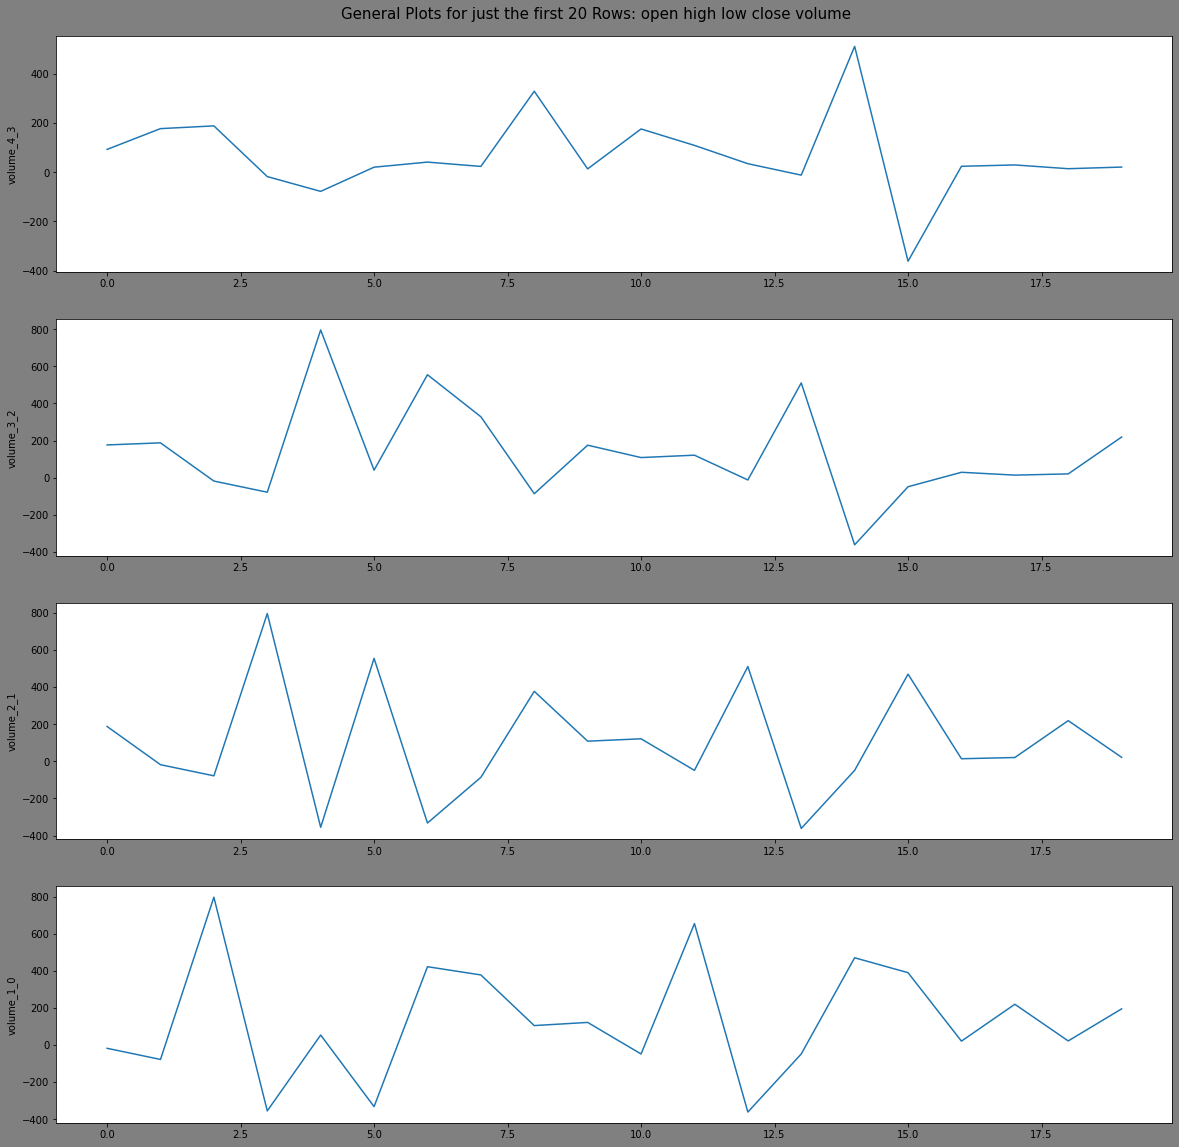

Plots for minutes:


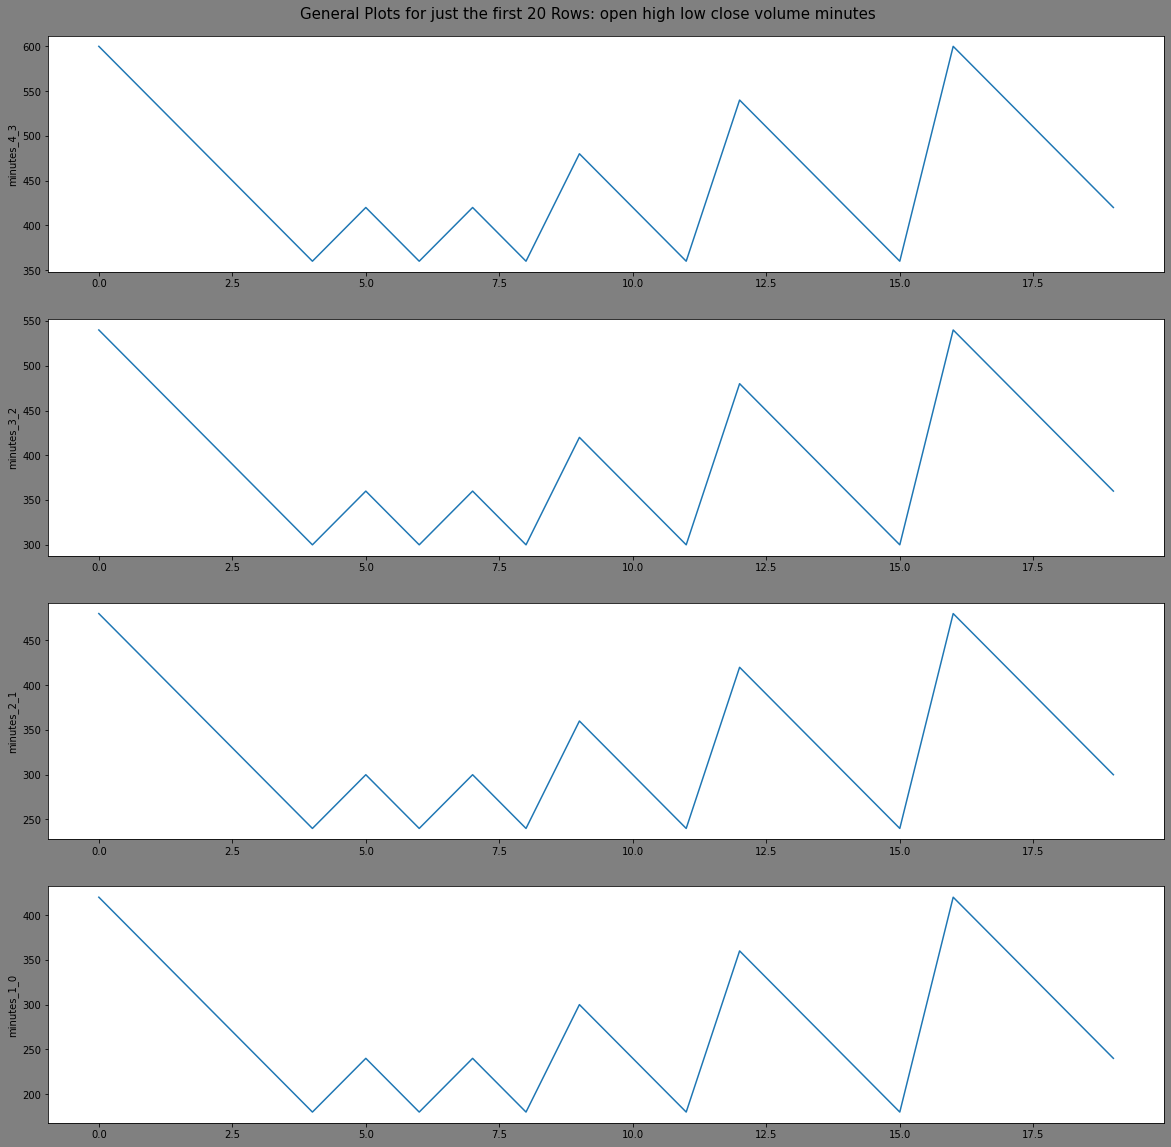

In [14]:
df_to_plot = X_train_window_size_5.copy()
title = "General Plots for just the first 20 Rows:"
plot_subplots_wrapper(df_to_plot.iloc[:20, :].reset_index(), title)

## Correlation

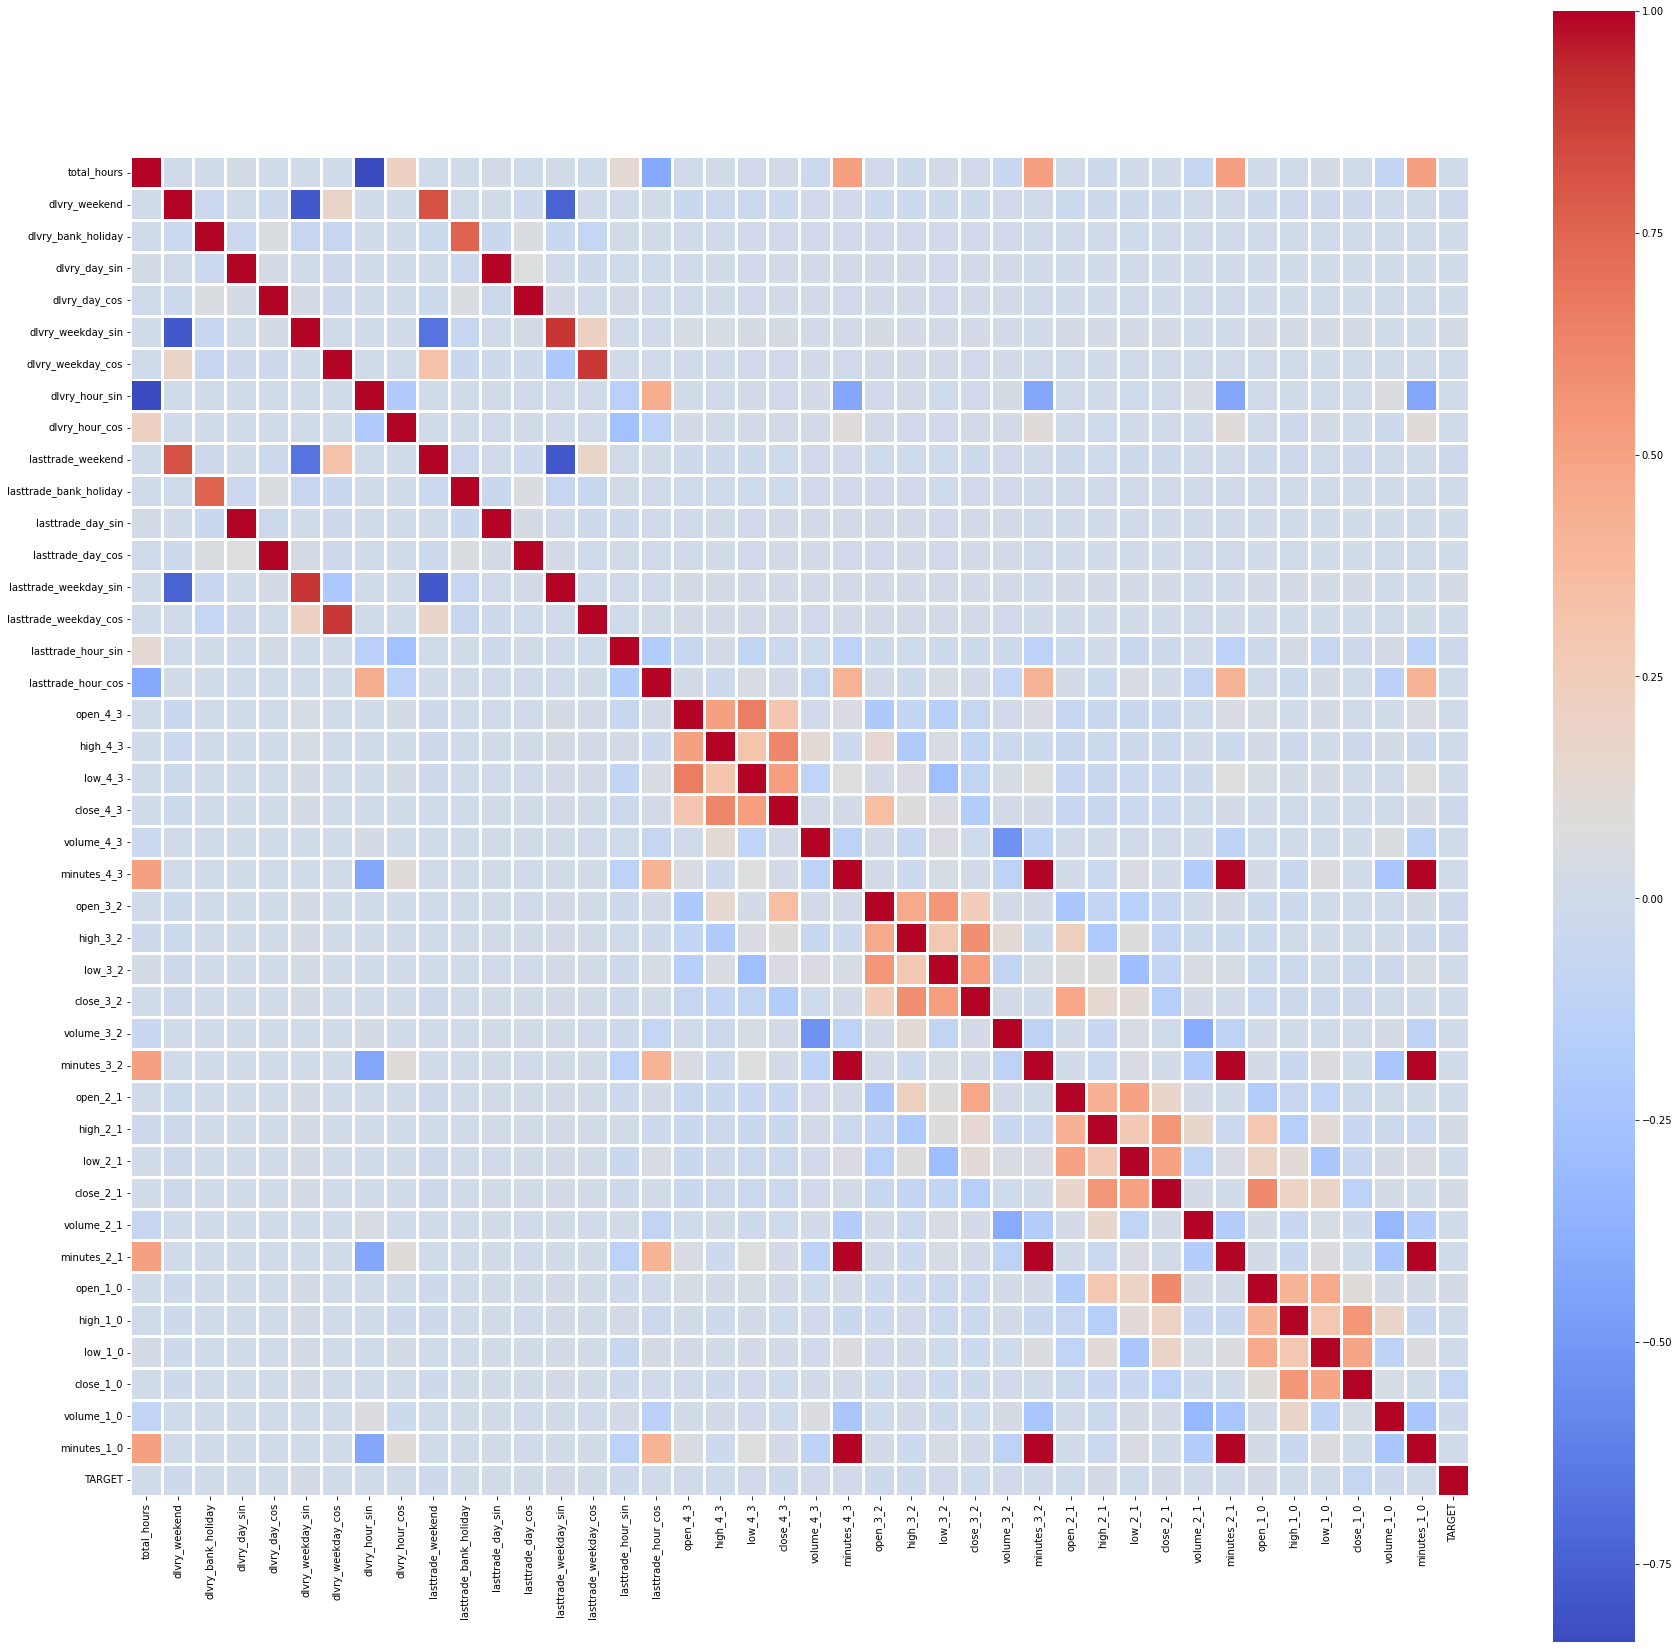

In [15]:
plt.figure(figsize=(30,30))
full_train_window_size_5 = X_train_window_size_5.copy()
full_train_window_size_5["TARGET"] = y_train_window_size_5["y"]
sns.heatmap(full_train_window_size_5.corr(), annot=False, linewidths = 2, square= True, cmap="coolwarm")
plt.show()

### The summary of the correlation matrix

# Creating Machine Learning models

## Preprocessing the data

### Make data tree-friendly: sin/cos features retransformation to make them work for tree-based approaches

Tree-based algorithms like Random Forest and Boosted Trees build their split rules according to one feature at a time. The cosine-sine transformation of features created 2 columns for every cyclical feature. If possible, we should retransform these 2 features to the original values to increase the chance of higher accuracy of the tree-based approaches.

There are 6 features (i.e., dlvry_day, dlvry_weekday, dlvry_hour, lasttrade_day, lasttrade_weekday, lasttrade_hour) encoded using a sine and cosine column respectively.

As one cannot simply solve the underlying sine and cosine transformations to the original value, we tried to reproduce the tranaformation in order to get the original values.

#### _weekday features

When we look at the values for the dlvry_weekday, we can see that there are 7 unique values, corresponding to the days of the week.

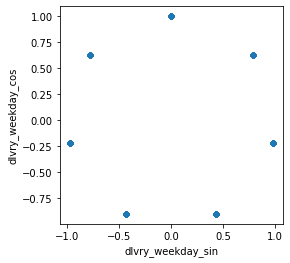

In [16]:
# plot sample of values
X_train_window_size_5.sample(500).plot.scatter('dlvry_weekday_sin','dlvry_weekday_cos').set_aspect('equal')

In [17]:
# look at unique values
X_train_window_size_5.groupby(['dlvry_weekday_sin', 'dlvry_weekday_cos']).size().reset_index().rename(columns={0:'count'})

,dlvry_weekday_sin,dlvry_weekday_cos,count
0,-0.974928,-0.222521,12722
1,-0.781831,0.623490,12738
2,-0.433884,-0.900969,13163
3,0.000000,1.000000,12923
4,0.433884,-0.900969,13283
5,0.781831,0.623490,13156
6,0.974928,-0.222521,13527


With that information, we can calculate our own sine and cosine features and create a mapping which is to be used for creating the original feature column for days of the week.

In [18]:
days_in_a_week = 7

mapping_day_of_week = {}

# apply cosine and sine transformaiton for every day of the week
for i in range(0, days_in_a_week):
    mapping_day_of_week[(round(np.sin(2*np.pi*i/days_in_a_week), 5), round(np.cos(2*np.pi*i/days_in_a_week), 5))] = i

mapping_day_of_week

{(-0.97493, -0.22252): 5,
 (-0.78183, 0.62349): 6,
 (-0.43388, -0.90097): 4,
 (0.0, 1.0): 0,
 (0.43388, -0.90097): 3,
 (0.78183, 0.62349): 1,
 (0.97493, -0.22252): 2}

In [19]:
# create function to convert sine- and cosine-transformed values back
def convert_weekday(sin, cos):
    """Return original value from sine- and cosine-transformed values

    Arguments:
    sin -- sine-transformed value
    cos -- cosine-transformed value"""
    weekday = mapping_day_of_week[(round(sin, 5), round(cos, 5))]
    return weekday

#### _hour features

When we look at the values for the dlvry_hour, we can see that there are most likely 24 possible values (points are distributed like a 24h clock, corresponding to the hours of the day.

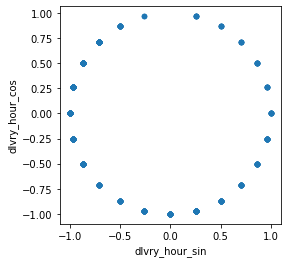

In [20]:
# plot sample of values
X_train_window_size_5.sample(500).plot.scatter('dlvry_hour_sin','dlvry_hour_cos').set_aspect('equal')

In [21]:
# look at unique values
hours = X_train_window_size_5.groupby(['lasttrade_hour_sin','lasttrade_hour_cos']).size().reset_index().rename(columns={0:'count'})
hours[["lasttrade_hour_sin", "lasttrade_hour_cos"]].round(5)

,lasttrade_hour_sin,lasttrade_hour_cos
0,-1.00000,-0.00000
1,-0.96593,-0.25882
2,-0.96593,0.25882
3,-0.86603,0.50000
4,-0.86603,-0.50000
5,-0.70711,0.70711
6,-0.70711,-0.70711
7,-0.50000,0.86603
8,-0.50000,-0.86603
9,-0.25882,0.96593


With that information, we can calculate our own sine and cosine features and create a mapping which is to be used for creating the original feature column for hours of the day.

In [22]:
hours_in_a_day = 24

mapping_hour_of_day = {}

# apply cosine and sine transformaiton for every hour of the day
for i in range(0, hours_in_a_day):
    mapping_hour_of_day[(round(np.sin(2*np.pi*i/hours_in_a_day), 5), round(np.cos(2*np.pi*i/hours_in_a_day), 5))] = i
                            
mapping_hour_of_day    

{(-1.0, -0.0): 18,
 (-0.96593, -0.25882): 17,
 (-0.96593, 0.25882): 19,
 (-0.86603, -0.5): 16,
 (-0.86603, 0.5): 20,
 (-0.70711, -0.70711): 15,
 (-0.70711, 0.70711): 21,
 (-0.5, -0.86603): 14,
 (-0.5, 0.86603): 22,
 (-0.25882, -0.96593): 13,
 (-0.25882, 0.96593): 23,
 (0.0, -1.0): 12,
 (0.0, 1.0): 0,
 (0.25882, -0.96593): 11,
 (0.25882, 0.96593): 1,
 (0.5, -0.86603): 10,
 (0.5, 0.86603): 2,
 (0.70711, -0.70711): 9,
 (0.70711, 0.70711): 3,
 (0.86603, -0.5): 8,
 (0.86603, 0.5): 4,
 (0.96593, -0.25882): 7,
 (0.96593, 0.25882): 5,
 (1.0, 0.0): 6}

In [23]:
# create function to convert sine- and cosine-transformed values back
def convert_hour(sin, cos):
    hour = mapping_hour_of_day[(round(sin, 5), round(cos, 5))]
    return hour

#### _day features

When we look at the values for the dlvry_day, we can see that there is no obvious patterns like we observed for the _hour and _weekday features.

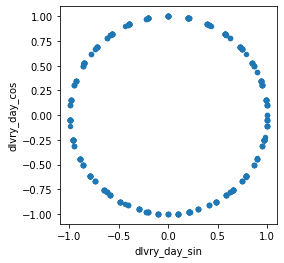

In [24]:
# plot sample of values
X_train_window_size_5.sample(500).plot.scatter('dlvry_day_sin','dlvry_day_cos').set_aspect('equal')

In [25]:
# look at unique values
year_days = X_train_window_size_5.groupby(['dlvry_day_sin','dlvry_day_cos']).size().reset_index().rename(columns={0:'count'})
year_days = year_days[['dlvry_day_sin','dlvry_day_cos']].round(5)
year_days

,dlvry_day_sin,dlvry_day_cos
0,-0.99872,-0.05065
1,-0.99452,0.10453
2,-0.99452,-0.10453
3,-0.98847,0.15143
4,-0.96808,-0.25065
...,...,...
77,0.98847,0.15143
78,0.99452,0.10453
79,0.99452,-0.10453
80,0.99872,-0.05065


Intuitively, we might assume that the transformation is based on 365 days in a year, but creating the respective mapping does not yield matches (see below), so we couldn't reproduce the sine and cosine features for the _day features.

In [26]:
days_in_a_year = 365

mapping_day = {}

for i in range(0, days_in_a_year):
    mapping_day[(round(np.sin(2*np.pi*i/days_in_a_year), 5), round(np.cos(2*np.pi*i/days_in_a_year), 5))] = i

# check whether there is a match with randomly picked values from the unique values above
try: 
    mapping_day[(0.98847, 0.15143)]
except KeyError:
    print("There is no match")

There is no match


#### transformation

In [27]:
def tree_transform(df, drop_day=True):
    """Return tree-friendly data with cos and sin features transformed back to original values

    Arguments:
    df -- dataset
    drop_day -- _day features cannot be transformed back, can be dropped or kept"""
    # create new columns for original values
    data = df.copy()
    data["dlvry_weekday"] = data.apply(lambda x: convert_weekday(x['dlvry_weekday_sin'], x['dlvry_weekday_cos']), axis=1)
    data["lasttrade_weekday"] = data.apply(lambda x: convert_weekday(x['lasttrade_weekday_sin'], x['lasttrade_weekday_cos']), axis=1)
    data["dlvry_hour"] = data.apply(lambda x: convert_hour(x['dlvry_hour_sin'], x['dlvry_hour_cos']), axis=1)
    data[["lasttrade_hour"]] = data.apply(lambda x: convert_hour(x['lasttrade_hour_sin'], x['lasttrade_hour_cos']), axis=1)

    # drop redundant sine and cosine features
    data = data.drop(['dlvry_weekday_sin', 'dlvry_weekday_cos', 'lasttrade_weekday_sin', 
                      'lasttrade_weekday_cos', 'dlvry_hour_sin', 'dlvry_hour_cos', 
                      'lasttrade_hour_sin', 'lasttrade_hour_cos'], axis=1)
    # drop _day features as we couldn't transform them back
    if drop_day:
        data = data.drop(['dlvry_day_cos', 'dlvry_day_sin', 'lasttrade_day_sin', 'lasttrade_day_cos'], axis=1)

    return data

In [28]:
# create tree-friendly datasets
X_train_window_size_5_tree = tree_transform(X_train_window_size_5)
X_valid_window_size_5_tree = tree_transform(X_valid_window_size_5)
X_test_window_size_5_tree = tree_transform(X_test_window_size_5)

### Normalization

In [29]:
scaler = MinMaxScaler()
X_train_window_size_5[X_train_window_size_5.columns[17:]] = scaler.fit_transform(X_train_window_size_5[X_train_window_size_5.columns[17:]])
X_valid_window_size_5[X_valid_window_size_5.columns[17:]] = scaler.transform(X_valid_window_size_5[X_valid_window_size_5.columns[17:]])
X_test_window_size_5[X_test_window_size_5.columns[17:]] = scaler.transform(X_test_window_size_5[X_test_window_size_5.columns[17:]])

#Quick note: It seems like the results are getting worse when normalizing the input set X

## Evaluation: Mean absolut error function

In [30]:
def evaluate_model(model, X_test, y_test_true):
    predictions = model.predict(X_test)
    mae = mean_absolute_error(y_test_true, predictions)
    print("Mean absolut error on test:", mae)
    return mae

## Function for training modesl with parameter grids

In [31]:
def cross_validation_training(model, X_train, y_train, param_grid):
    CV_model = GridSearchCV(estimator=model, param_grid=param_grid, cv=5,
                            scoring='neg_mean_absolute_error', n_jobs=-1,
                            verbose=3)
    CV_model.fit(X_train, y_train)
    print('The best combination of parameters is', CV_model.best_params_)
    
    model = model.set_params(**CV_model.best_params_)
    model.fit(X_train, y_train)
    return model

## Dummy regressor

In [32]:
dummy_model = DummyRegressor()

dummy_model.fit(X_train_window_size_5, y_train_window_size_5)

DummyRegressor(constant=None, quantile=None, strategy='mean')

In [33]:
result = evaluate_model(dummy_model, X_test_window_size_5, y_test_window_size_5)

Mean absolut error on test: 2.258751650277334


## Linear Regression

In [ ]:
########## Helper functions for the linear models
##### Function to perform Cross Validation on Linear Models
def get_cv_scores(model, X_train, y_train):
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    print('CV Mean of R2: ', np.mean(scores))
    print('CV STD of R2: ', np.std(scores))

##### Function to evaluate Linear Models
def evaluate_valid(model, X_valid, y_valid, X_test, y_test):
    predictions_valid = model.predict(X_valid)
    mae_valid = mean_absolute_error(y_valid, predictions_valid)
    r2_valid = r2_score(y_valid, predictions_valid)
    print("Validation MAE:", mae_valid)
    print("Validation R2:", r2_valid)

    predictions_test = model.predict(X_test)
    mae_test = mean_absolute_error(y_test, predictions_test)
    r2_test = r2_score(y_test, predictions_test)
    print("Test MAE:", mae_test)
    print("Test R2:", r2_test)
    
    fig=plt.figure()
    ax=fig.add_axes([0,0,1,1])
    ax.scatter(y_valid, predictions_valid, color='r', label='valid set', alpha=0.2)
    ax.scatter(y_test, predictions_test, color='b', label='test set', alpha=0.2)
    ax.set_title('Distributions of predicted and real Y')
    ax.set_xlabel('Actual Y')
    ax.set_ylabel('Predicted Y')
    ax.legend()

CV Mean of R2:  -0.002522543666167487
CV STD of R2:  0.011866667913725957
Validation MAE: 2.5599750432288126
Validation R2: -0.006820715285187129
Test MAE: 2.280769741554558
Test R2: -0.004377072267172766
Independent term in the linear model:  [15.15008165]
Estimated coefficients in the linear regression:  [[ 6.95043714e-03  7.96772665e-02 -1.55488576e-01 -1.46959290e-01
   1.14062518e-01  5.10299566e-03 -7.92898125e-03  1.20597840e-02
  -4.74398992e-03  4.36772029e-02  2.96955198e-01  1.92131609e-01
  -7.04525437e-02  1.17194886e-01 -5.00321151e-03 -1.19627472e-01
   7.42059115e-03 -4.52679867e+00  8.79464443e+00  5.79462325e+00
  -6.74630586e+00 -1.87017293e-01 -3.59060881e-02 -5.81444261e+00
   1.66330755e+01  4.08459975e+00 -6.66371945e+00 -5.21487449e+00
  -3.59060881e-02 -6.29933194e+00  2.26438098e+01  1.77836773e-01
  -9.40376768e+00 -1.88335729e+01 -3.59060881e-02 -1.67316734e+00
   1.63949530e+01  3.29534288e+00 -2.84652121e+01 -2.42357425e+01
  -3.59060881e-02 -4.26170526e-0

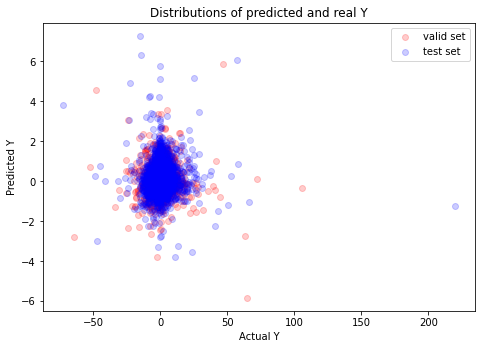

In [ ]:
##### Direct Linear Modling on Original Data 
model_lr = LinearRegression(copy_X=True, n_jobs=100)
model_lr.fit(X_train_window_size_5, y_train_window_size_5)
get_cv_scores(model_lr, X_train_window_size_5, y_train_window_size_5)
evaluate_valid(model_lr, X_valid_window_size_5, y_valid_window_size_5, X_test_window_size_5, y_test_window_size_5)
print('Independent term in the linear model: ', model_lr.intercept_)
print('Estimated coefficients in the linear regression: ', model_lr.coef_)

CV Mean of R2:  -7.436812124717283e+16
CV STD of R2:  1.0413512441091712e+17
Validation MAE: 2.7916502664513376
Validation R2: -0.22072640460724635
Test MAE: 2.4725614480729954
Test R2: -0.07472644618502833


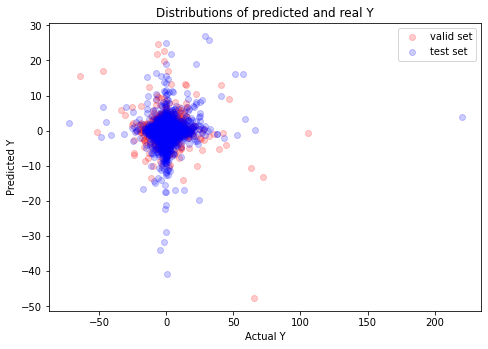

In [ ]:
##### Polynomial Regression (Degree=2) 
# Transformation of X_train/valid/test
polynomial_features= PolynomialFeatures(degree=2)
X_train_5_poly = polynomial_features.fit_transform(X_train_window_size_5)
X_valid_5_poly = polynomial_features.fit_transform(X_valid_window_size_5)
X_test_5_poly = polynomial_features.fit_transform(X_test_window_size_5)

# Model Fitting & Results
model_lr = LinearRegression(normalize=True, copy_X=True, n_jobs=100)
model_lr.fit(X_train_5_poly, y_train_window_size_5)
get_cv_scores(model_lr, X_train_5_poly, y_train_window_size_5)
evaluate_valid(model_lr, X_valid_5_poly, y_valid_window_size_5, X_test_5_poly, y_test_window_size_5)

## RandomForrest Regressor

In [ ]:
rfmodel = RandomForestRegressor(random_state=3315, 
                                max_depth=8,
                                n_estimators=200,
                                criterion='mse', n_jobs=4)
rfmodel.fit(X_train_window_size_5_tree, y_train_window_size_5)

RandomForestRegressor(max_depth=8, n_estimators=200, n_jobs=4,
                      random_state=3315)

In [ ]:
result = evaluate_model(rfmodel, X_test_window_size_5_tree, y_test_window_size_5)

Mean absolut error on test: 2.2857521348109544


## Gradient Boosting on Decision Trees (CatBoost and XGB)

### LightGBM Model

In [41]:
X_train_window_size_5_tree = X_train_window_size_5_tree.drop(['total_hours','minutes_4_3', 'minutes_3_2', 'minutes_2_1', 'dlvry_weekend', 'volume_4_3','volume_3_2', 'volume_2_1'], axis=1)
X_valid_window_size_5_tree = X_valid_window_size_5_tree.drop(['total_hours','minutes_4_3', 'minutes_3_2', 'minutes_2_1', 'dlvry_weekend', 'volume_4_3','volume_3_2', 'volume_2_1'], axis=1)
X_test_window_size_5_tree = X_test_window_size_5_tree.drop(['total_hours', 'minutes_4_3', 'minutes_3_2', 'minutes_2_1', 'dlvry_weekend', 'volume_4_3','volume_3_2', 'volume_2_1'], axis=1)

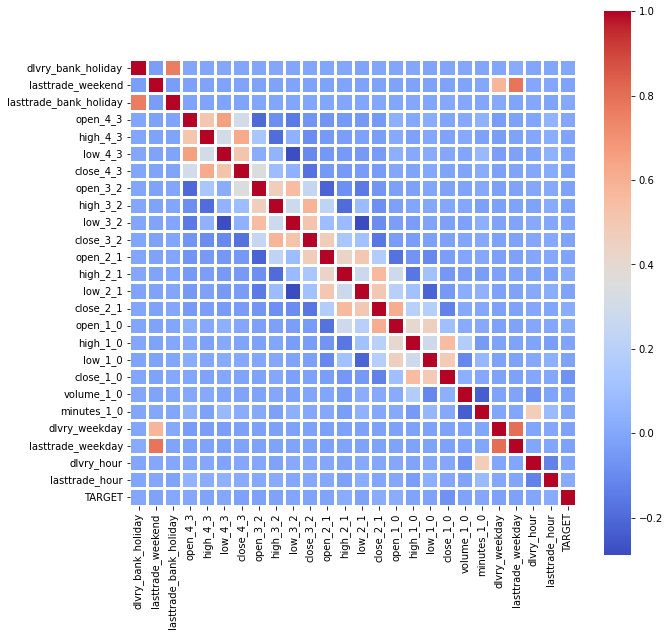

In [42]:
plt.figure(figsize=(10,10))
full_train_window_size_5 = X_train_window_size_5_tree.copy()
full_train_window_size_5["TARGET"] = y_train_window_size_5["y"]
sns.heatmap(full_train_window_size_5.corr(), annot=False, linewidths = 2, square= True, cmap="coolwarm")
plt.show()

In [43]:
train_data = lgb.Dataset(X_train_window_size_5_tree, label=y_train_window_size_5)
valid_data = lgb.Dataset(X_valid_window_size_5_tree, label=y_valid_window_size_5)
test_data = lgb.Dataset(X_test_window_size_5_tree, label=y_test_window_size_5)

In [44]:
param = {'num_leaves': 38, 'objective': 'regression_l1', 'metric': 'mae'}
num_round =17
bst = lgb.train(param, train_data, num_round, valid_sets=[valid_data])

[1]	valid_0's l1: 2.55466
[2]	valid_0's l1: 2.55436
[3]	valid_0's l1: 2.55373
[4]	valid_0's l1: 2.55288
[5]	valid_0's l1: 2.55318
[6]	valid_0's l1: 2.55347
[7]	valid_0's l1: 2.55335
[8]	valid_0's l1: 2.55299
[9]	valid_0's l1: 2.55306
[10]	valid_0's l1: 2.55255
[11]	valid_0's l1: 2.55216
[12]	valid_0's l1: 2.55203
[13]	valid_0's l1: 2.5511
[14]	valid_0's l1: 2.55088
[15]	valid_0's l1: 2.55049
[16]	valid_0's l1: 2.55001
[17]	valid_0's l1: 2.55073


In [45]:
result = evaluate_model(bst, X_test_window_size_5_tree, y_test_window_size_5)

Mean absolut error on test: 2.2483066265867726


## Support Vector Machine Regression

In [ ]:
svrmodel = SVR(kernel='poly', C=20)

svrmodel.fit(X_train_window_size_5, y_train_window_size_5)

SVR(C=20, kernel='poly')

In [ ]:
result = evaluate_model(svrmodel, X_test_window_size_5, y_test_window_size_5)

Mean absolut error on test: 2.260098588031554


## K-Nearest Neighbours

The optimal k was found doing a grid search for `range(3, 25)`.  

For this 'classic' approach, the train and valid set will be put together to make use of cross-validation.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

X_train_window_size_5_classic = X_train_window_size_5.copy().append(X_valid_window_size_5)
y_train_window_size_5_classic = y_train_window_size_5.copy().append(y_valid_window_size_5)

minmax_transformer_classic = Pipeline(steps=[
        ('minmax', MinMaxScaler())])

preprocessor_window_size_5_classic = ColumnTransformer(
        remainder='passthrough', #passthough features not listed
        transformers=[
            ('mm', minmax_transformer_classic , [X_train_window_size_5_classic.columns[1], *[*X_train_window_size_5_classic.columns[17:]]])
        ])


preprocessor_window_size_5_classic.fit(X_train_window_size_5, y_train_window_size_5)
X_train_window_size_5_classic_norm = preprocessor_window_size_5_classic.transform(X_train_window_size_5_classic)
X_test_window_size_5_classic_norm = preprocessor_window_size_5_classic.transform(X_test_window_size_5)

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.neighbors import KNeighborsRegressor

class Knn:

    def __init__(self,
                 X_train: pd.DataFrame,
                 X_test: pd.DataFrame,
                 y_train: pd.DataFrame,
                 y_test: pd.DataFrame,
                 k: int):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.k = k
        self.model = KNeighborsRegressor(n_neighbors=self.k, n_jobs=-1)
        self.mae_scorer = make_scorer(mean_absolute_error)
    
    def get_cv_scores(self):
        return cross_val_score(self.model, self.X_train, self.y_train, cv=5, scoring=self.mae_scorer)

    def fit(self):
        self.model.fit(self.X_train, self.y_train)

    def predict(self):
        predictions = self.model.predict(self.X_test)
        return predictions

    def go(self):
        cv_scores = self.get_cv_scores()
        self.fit()
        predictions = self.predict()
        return cv_scores, predictions, self.model

In [ ]:
knn_5 = Knn(
    X_train_window_size_5_classic_norm,
    X_test_window_size_5_classic_norm,
    y_train_window_size_5_classic,
    y_test_window_size_5,
    k=3
)

knn_cv_scores_5, knn_predictions_5, knn_model_5 = knn_5.go()

CV Scores for KNN

In [ ]:
knn_cv_scores_5

array([2.16796654, 2.01141579, 2.32734974, 2.23319267, 2.45716533])

Prediction Scores for KNN

In [ ]:
knn_predictions_5

array([[-0.15333333],
       [-0.15333333],
       [ 0.39      ],
       ...,
       [ 0.63      ],
       [ 1.07      ],
       [ 1.07      ]])

# Creating Deep Learning Models

## Preprocessing the data to 3D for Recurrent Neural Networks

In [ ]:
def unflatten_ohlcv(data, window_size):
    """Return 3D data for open, high, low, close and volume (ohlcv) 
    to make the data suitable for recurrent neural networks

    Arguments:
    data -- input data
    window_size -- 5 or 15 depending on dataset
    """

    if window_size == 5:
        # only keep open, high, low, close and volume features
        X = data.iloc[:,17:] 
        # drop minutes left feature as it is a linear function of time
        X = X.drop(["5", "11", "17", "23"], axis = 1)
        # apply MinMax scaling
        mmscaler = MinMaxScaler()
        X[X.columns] = mmscaler.fit_transform(X[X.columns])
        # give meaningful names to columns
        X = X.rename(columns={"0": "open_t-4", "1": "high_t-4", "2": "low_t-4",
                              "3": "close_t-4", "4": "vol_t-4", "6": "open_t-3",
                              "7": "high_t-3", "8": "low_t-3", "9": "close_t-3",
                              "10": "vol_t-3",  "12": "open_t-2", "13": "high_t-2",
                              "14": "low_t-2", "15": "close_t-2", "16": "vol_t-2",
                              "18": "open_t-1", "19": "high_t-1", "20": "low_t-1",
                              "21": "close_t-1", "22": "vol_t-1"})

        # separate data per feature
        X_open = X[["open_t-4", "open_t-3", "open_t-2", "open_t-1"]]
        X_high = X[["high_t-4", "high_t-3", "high_t-2", "high_t-1"]]
        X_low = X[["low_t-4", "low_t-3", "low_t-2", "low_t-1"]]
        X_close = X[["close_t-4", "close_t-3", "close_t-2", "close_t-1"]]
        X_vol = X[["vol_t-4", "vol_t-3", "vol_t-2", "vol_t-1"]]

        # stack data
        X = np.stack([X_open, X_high, X_low, X_close, X_vol], axis = 2)

        return X
      
    if window_size == 15:
        # only keep open, high, low, close and volume features
        X = data.iloc[:,17:] 
        # drop minutes left feature as it is a linear function of time
        X = X.drop(["5", "11", "17", "23", "29", "35", "41", "47", "53", "59", "65",
                    "71", "77", "83"], axis = 1)
        # apply MinMax scaling
        mmscaler = MinMaxScaler()
        X[X.columns] = mmscaler.fit_transform(X[X.columns])
        # give meaningful names to columns
        X = X.rename(columns={"0": "open_t-14", "1": "high_t-14", "2": "low_t-14",
                              "3": "close_t-14", "4": "vol_t-14", "6": "open_t-13",
                              "7": "high_t-13", "8": "low_t-13", "9": "close_t-13",
                              "10": "vol_t-13", "12": "open_t-12", "13": "high_t-12",
                              "14": "low_t-12", "15": "close_t-12", "16": "vol_t-12",
                              "18": "open_t-11", "19": "high_t-11", "20": "low_t-11",
                              "21": "close_t-11", "22": "vol_t-11", "24": "open_t-10",
                              "25": "high_t-10", "26": "low_t-10", "27": "close_t-10",
                              "28": "vol_t-10", "30": "open_t-9", "31": "high_t-9",
                              "32": "low_t-9", "33": "close_t-9", "34": "vol_t-9",
                              "36": "open_t-8", "37": "high_t-8", "38": "low_t-8",
                              "39": "close_t-8", "40": "vol_t-8", "42": "open_t-7",
                              "43": "high_t-7", "44": "low_t-7", "45": "close_t-7",
                              "46": "vol_t-7", "48": "open_t-6", "49": "high_t-6",
                              "50": "low_t-6", "51": "close_t-6", "52": "vol_t-6",
                              "54": "open_t-5", "55": "high_t-5", "56": "low_t-5",
                              "57": "close_t-5", "58": "vol_t-5", "60": "open_t-4",
                              "61": "high_t-4", "62": "low_t-4", "63": "close_t-4",
                              "64": "vol_t-4", "66": "open_t-3", "67": "high_t-3",
                              "68": "low_t-3", "69": "close_t-3", "70": "vol_t-3",
                              "72": "open_t-2", "73": "high_t-2", "74": "low_t-2",
                              "75": "close_t-2", "76": "vol_t-2", "78": "open_t-1",
                              "79": "high_t-1", "80": "low_t-1", "81": "close_t-1",
                              "82": "vol_t-1"})

        # separate data per feature
        X_open = X[["open_t-14", "open_t-13", "open_t-12", "open_t-11", "open_t-10",
                    "open_t-9", "open_t-8", "open_t-7", "open_t-6", "open_t-5",
                    "open_t-4", "open_t-3", "open_t-2", "open_t-1"]]
        X_high = X[["high_t-14", "high_t-13", "high_t-12", "high_t-11", "high_t-10",
                    "high_t-9", "high_t-8", "high_t-7", "high_t-6", "high_t-5",
                    "high_t-4", "high_t-3", "high_t-2", "high_t-1"]]
        X_low = X[["low_t-14", "low_t-13", "low_t-12", "low_t-11", "low_t-10",
                   "low_t-9", "low_t-8", "low_t-7", "low_t-6", "low_t-5", "low_t-4",
                   "low_t-3", "low_t-2", "low_t-1"]]
        X_close = X[["close_t-14", "close_t-13", "close_t-12", "close_t-11",
                     "close_t-10", "close_t-9", "close_t-8", "close_t-7",
                     "close_t-6", "close_t-5", "close_t-4", "close_t-3",
                     "close_t-2", "close_t-1"]]
        X_vol = X[["vol_t-14", "vol_t-13", "vol_t-12", "vol_t-11", "vol_t-10",
                   "vol_t-9", "vol_t-8", "vol_t-7", "vol_t-6", "vol_t-5",
                   "vol_t-4", "vol_t-3", "vol_t-2", "vol_t-1"]]

        # stack data
        X = np.stack([X_open, X_high, X_low, X_close, X_vol], axis = 2)

        return X

## Mulit-Layer Perceptron

### Takeaway
For the MLP, the architecture seemed to be rather irrelevant. Generally speaking, simpler architectures with less neurons seemed to work as well as more complex architectures with several hidden layers and/or a large number of neurons. In total, a few hundred neurons overall were enough. Dropout, LR Scheduling and Adam optimizer created the best results.  
We also found that higher batch sizes decreased the MAE.  
One interesting finding is that the performance on the validation set would not change after 2-3 epochs. Additionally, the performance on the test set was always better than the performance on the validation set.

In [ ]:
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras import backend as be
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.math import exp
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping


class Mlp:
    """
    Creates a multilayer-perceptron model.
    """
    def __init__(self, 
                 X_train: pd.DataFrame, 
                 X_valid: pd.DataFrame, 
                 X_test: pd.DataFrame, 
                 y_train: pd.DataFrame, 
                 y_valid: pd.DataFrame, 
                 y_test: pd.DataFrame, 
                 params: dict, 
                 layers: list, 
                 dropout: bool,
                 schedulerthresh: int,
                 optimizer,
                 earlystopping: int
                 ):
        self.X_train = X_train
        self.X_valid = X_valid
        self.X_test = X_test
        self.y_train = y_train
        self.y_valid = y_valid
        self.y_test = y_test
        self.params = params
        self.layers = layers
        self.dropout = dropout
        self.schedulerthresh = schedulerthresh
        self.optimizer = optimizer
        self.earlystopping = earlystopping
        self.model = Sequential()

    def compile_model(self):
        be.clear_session()
        self.model.add(Input(shape=(self.X_train.shape[1])))
        for i in range(len(self.layers)):
            self.model.add(Dense(self.layers[i], activation="relu"))
            if self.dropout:
                self.model.add(Dropout(rate=self.dropout))
        self.model.add(Dense(1, activation="linear"))
        optimizer = self.optimizer
        self.model.compile(loss='mean_absolute_error', optimizer=optimizer)
        return self.model
        
    def fit_model(self):
        callbacks = []
        if self.scheduler:
            callbacks.append(LearningRateScheduler(self.scheduler))
        if self.earlystopping:
            callbacks.append(EarlyStopping(monitor='loss', patience=self.earlystopping))
        history = self.model.fit(x=self.X_train,y=self.y_train, batch_size=self.params["BATCH_SIZE"], validation_data=(self.X_valid,self.y_valid), epochs=self.params["EPOCHS"], callbacks=callbacks, verbose=1, shuffle=False)
        return history, self.model

    def evaluate_model(self):
        eval_score = self.model.evaluate(self.X_test, self.y_test.to_numpy())
        return eval_score, self.model

    def predict(self):
        return self.model.predict(self.X_test)
      
    def go(self):
        self.compile_model()
        history, _ = self.fit_model()
        eval_score, _ = self.evaluate_model()
        predictions = self.predict()
        return history, eval_score, predictions, self.model
        
    def scheduler(self, epoch, lr):
        if self.schedulerthresh:
            thresh = self.schedulerthresh
        else:
            thresh = 5
        if epoch < thresh:
            return lr
        else:
            return lr*exp(-0.1)


### Creating best model for MLP

In [ ]:
params = {
    "BATCH_SIZE": 2048, 
    "EPOCHS": 10, 
    "LEARNING_RATE": 0.0005}
layers = [300, 100]
dropout = 0.25
scheduler = 5
optimizer = Adam(learning_rate=0.0005)
earlystopping = 3

mlp_5 = Mlp(
    X_train_window_size_5,
    X_valid_window_size_5,
    X_test_window_size_5,
    y_train_window_size_5,
    y_valid_window_size_5,
    y_test_window_size_5,
    params,
    layers,
    dropout,
    scheduler,
    optimizer,
    earlystopping
)
mlp_history_5, mlp_eval_score_5, mlp_predictions_5, mlp_model_5 = mlp_5.go()

Epoch 1/10
45/45 [==============================] - 2s 32ms/step - loss: 1.9335 - val_loss: 2.5619
Epoch 2/10
45/45 [==============================] - 1s 27ms/step - loss: 1.7948 - val_loss: 2.5553
Epoch 3/10
45/45 [==============================] - 1s 27ms/step - loss: 1.7773 - val_loss: 2.5553
Epoch 4/10
45/45 [==============================] - 1s 27ms/step - loss: 1.7730 - val_loss: 2.5551
Epoch 5/10
45/45 [==============================] - 1s 27ms/step - loss: 1.7719 - val_loss: 2.5551
Epoch 6/10
45/45 [==============================] - 1s 27ms/step - loss: 1.7714 - val_loss: 2.5552
Epoch 7/10
45/45 [==============================] - 1s 26ms/step - loss: 1.7712 - val_loss: 2.5551
Epoch 8/10
45/45 [==============================] - 1s 27ms/step - loss: 1.7711 - val_loss: 2.5551
Epoch 9/10
45/45 [==============================] - 1s 29ms/step - loss: 1.7710 - val_loss: 2.5551
Epoch 10/10
335/335 [==============================] - 1s 2ms/step - loss: 2.2551


Evaluation Score of MLP

In [ ]:
mlp_eval_score_5

2.2551374435424805

Plotting the Convergence process

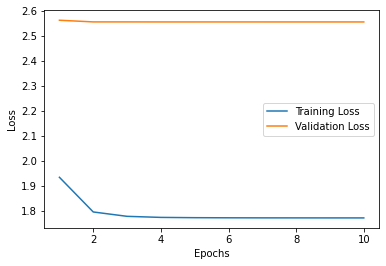

In [ ]:
import matplotlib.pyplot as plt

loss_values = mlp_history_5.history['loss']
val_loss_values = mlp_history_5.history['val_loss']
epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, label='Training Loss')
plt.plot(epochs, val_loss_values, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Rolling data

In [ ]:
def unflatten_ohlcv(data):
    """Return 3D data for open, high, low, close and volume (ohlcv) 
    to make the data suitable for recurrent neural networks

    Arguments:
    data -- predictor data after renaming and normalization
    """

    # only keep open, high, low, close and volume features
    X = data.iloc[:,17:] 
    # drop minutes left feature as it is a linear function of time
    minute_col = [col for col in X.columns if 'minutes' in col]
    X = X.drop(minute_col, axis = 1)

    # separate data per feature
    open_col = [col for col in X.columns if 'open' in col]
    X_open = X[open_col]
    high_col = [col for col in X.columns if 'high' in col]
    X_high = X[high_col]
    low_col = [col for col in X.columns if 'low' in col]
    X_low = X[low_col]
    close_col = [col for col in X.columns if 'close' in col]
    X_close = X[close_col]
    vol_col = [col for col in X.columns if 'volume' in col]
    X_vol = X[vol_col]

    # stack data
    X = np.stack([X_open, X_high, X_low, X_close, X_vol], axis = 2)

    return X

In [ ]:
X_train_unflatten_5 = unflatten_ohlcv(X_train_window_size_5)
X_valid_unflatten_5 = unflatten_ohlcv(X_valid_window_size_5)
X_test_unflatten_5 = unflatten_ohlcv(X_test_window_size_5)
np.shape(X_train_unflatten_5), np.shape(X_valid_unflatten_5), np.shape(X_test_unflatten_5)

((91512, 4, 5), (4817, 4, 5), (10704, 4, 5))

In [ ]:
def unflatten_all(data, window_size):
    """Return 3D data for all features (except minutes left) 
    to make the data suitable for recurrent neural networks

    Arguments:
    data -- predictor data after renaming and normalization
    window_size -- either 5 or 15
    """

    timesteps = window_size - 1

    X_no_ts = []

    # copy every non time series feature to get right shape
    for feature in data.iloc[:,:17].columns:
      X_feat = pd.concat([data[feature]]*timesteps, axis=1)
      X_no_ts.append(X_feat)
    
    # only keep open, high, low, close and volume features
    X = data.iloc[:,17:] 
    # drop minutes left feature as it is a linear function of time
    minute_col = [col for col in X.columns if 'minutes' in col]
    X = X.drop(minute_col, axis = 1)

    # separate data per feature
    open_col = [col for col in X.columns if 'open' in col]
    X_open = X[open_col]
    high_col = [col for col in X.columns if 'high' in col]
    X_high = X[high_col]
    low_col = [col for col in X.columns if 'low' in col]
    X_low = X[low_col]
    close_col = [col for col in X.columns if 'close' in col]
    X_close = X[close_col]
    vol_col = [col for col in X.columns if 'volume' in col]
    X_vol = X[vol_col]

    # all seperate data
    X_all_feat = [X_open, X_high, X_low, X_close, X_vol]
    X_all_feat.extend(X_no_ts)

    # stack data
    X = np.stack(X_all_feat, axis = 2)

    return X

In [ ]:
X_train_unflatten_all_5 = unflatten_all(X_train_window_size_5, 5)
X_valid_unflatten_all_5 = unflatten_all(X_valid_window_size_5, 5)
X_test_unflatten_all_5 = unflatten_all(X_test_window_size_5, 5)
np.shape(X_train_unflatten_all_5), np.shape(X_valid_unflatten_all_5), np.shape(X_test_unflatten_all_5)

In [ ]:
def evaluate_3Dmodel(model, X_test, y_test_true):
    predictions = model.predict(X_test)
    predictions = predictions[:, -1]
    mae = mean_absolute_error(y_test_true, predictions)
    print("Mean absolut error on test:", mae)
    return mae

## Convolutional Neural Network

In [ ]:
from tensorflow.keras.layers import Conv1D, Dropout, MaxPool1D, Dense, Embedding

In [ ]:
n_hidden_layers = 2
hidden_layer_size = 200
dropout_rate = 0.5

BATCH_SIZE = 200
EPOCHS = 50

In [ ]:
tf.compat.v1.reset_default_graph()
be.clear_session()

column_count = np.shape(X_train_unflatten_5)[2]
input_shape = np.shape(X_train_unflatten_5)

input_layer=Input(shape=(4, column_count))

cnn_layer=Conv1D(filters=10, kernel_size=2, 
                 activation='relu',
                 input_shape=input_shape[1:])(input_layer)

pool = MaxPool1D(pool_size=2, strides=1)(cnn_layer)
cur_last_layer = pool

for l in range(n_hidden_layers):
    dense = Dense(hidden_layer_size, activation='sigmoid')(cur_last_layer)
    dropout_layer = Dropout(dropout_rate)(dense)
    cur_last_layer=dropout_layer

predictions=Dense(1)(cur_last_layer)

cnn_model=Model(inputs=input_layer, outputs=predictions)
cnn_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4, 5)]            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 3, 10)             110       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2, 10)             0         
_________________________________________________________________
dense (Dense)                (None, 2, 200)            2200      
_________________________________________________________________
dropout (Dropout)            (None, 2, 200)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 2, 200)            40200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 200)            0     

In [ ]:
optimizer = Adam(learning_rate=0.001)
cnn_model.compile(loss='mean_absolute_error', optimizer=optimizer)

cnn_history = cnn_model.fit(X_train_unflatten_5, y_train_window_size_5,
                            validation_data=(X_valid_unflatten_5, y_valid_window_size_5),
                            shuffle=False,
                            epochs=EPOCHS,
                            batch_size=BATCH_SIZE)

Epoch 1/50
458/458 [==============================] - 3s 5ms/step - loss: 1.8194 - val_loss: 2.5560
Epoch 2/50
458/458 [==============================] - 2s 5ms/step - loss: 1.7734 - val_loss: 2.5555
Epoch 3/50
458/458 [==============================] - 2s 5ms/step - loss: 1.7718 - val_loss: 2.5553
Epoch 4/50
458/458 [==============================] - 2s 5ms/step - loss: 1.7713 - val_loss: 2.5552
Epoch 5/50
458/458 [==============================] - 2s 5ms/step - loss: 1.7711 - val_loss: 2.5552
Epoch 6/50
458/458 [==============================] - 2s 4ms/step - loss: 1.7710 - val_loss: 2.5552
Epoch 7/50
458/458 [==============================] - 2s 4ms/step - loss: 1.7710 - val_loss: 2.5551
Epoch 8/50
458/458 [==============================] - 2s 4ms/step - loss: 1.7709 - val_loss: 2.5551
Epoch 9/50
458/458 [==============================] - 2s 5ms/step - loss: 1.7709 - val_loss: 2.5551
Epoch 10/50
458/458 [==============================] - 2s 5ms/step - loss: 1.7709 - val_loss: 2.5551

In [ ]:
result = evaluate_3Dmodel(cnn_model, X_valid_unflatten_5, y_valid_window_size_5)

Mean absolut error on test: 2.5551403220353284


In [ ]:
result = evaluate_3Dmodel(cnn_model, X_test_unflatten_5, y_test_window_size_5)

Mean absolut error on test: 2.255138451202651


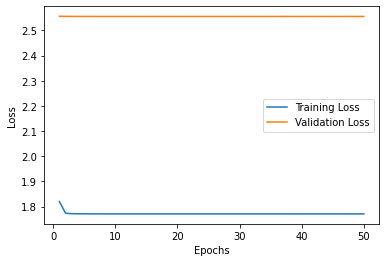

In [ ]:
loss_values = cnn_history.history['loss']
val_loss_values = cnn_history.history['val_loss']
epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, label='Training Loss')
plt.plot(epochs, val_loss_values, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Recurrent Neural Network

### LSTM: Long-Short-Term Memory

In [ ]:
n_hidden_layers = 2
hidden_layer_size = 200
# dropout_rate = 0.5

BATCH_SIZE = 500
EPOCHS = 50

In [56]:
from tensorflow.keras.backend import clear_session
from tensorflow.keras import backend as be
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adadelta, Adam, RMSprop

In [ ]:
tf.compat.v1.reset_default_graph()
clear_session

column_count = np.shape(X_train_unflatten_5)[2]

input_layer=Input(shape=(np.shape(X_train_unflatten_5)[1], column_count))
cur_last_layer=input_layer

for l in range(n_hidden_layers):
    hidden_layer=LSTM(hidden_layer_size, return_sequences=True)(cur_last_layer)
    cur_last_layer=hidden_layer

dense = Dense(100, activation='relu')(cur_last_layer)
dropout_layer = Dropout(0.3)(dense)
predictions=Dense(1)(dropout_layer)

lstm_model=Model(inputs=input_layer, outputs=predictions)
lstm_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4, 5)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 4, 200)            164800    
_________________________________________________________________
lstm_1 (LSTM)                (None, 4, 200)            320800    
_________________________________________________________________
dense (Dense)                (None, 4, 100)            20100     
_________________________________________________________________
dropout (Dropout)            (None, 4, 100)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 4, 1)              101       
Total params: 505,801
Trainable params: 505,801
Non-trainable params: 0
_______________________________________________________

In [ ]:
#For shape remeber, we have a variable defining the "window" and the features in the window...
optimizer = Adam(learning_rate=0.001)
lstm_model.compile(loss='mean_absolute_error', optimizer=optimizer)

lstm_history = lstm_model.fit(X_train_unflatten_5, y_train_window_size_5,
                              validation_data=(X_valid_unflatten_5, y_valid_window_size_5),
                              shuffle=False,
                              epochs=EPOCHS,
                              batch_size=BATCH_SIZE)

Epoch 1/50
184/184 [==============================] - 19s 83ms/step - loss: 1.7709 - val_loss: 2.5551
Epoch 2/50
184/184 [==============================] - 13s 71ms/step - loss: 1.7708 - val_loss: 2.5552
Epoch 3/50
184/184 [==============================] - 14s 76ms/step - loss: 1.7708 - val_loss: 2.5552
Epoch 4/50
184/184 [==============================] - 14s 74ms/step - loss: 1.7708 - val_loss: 2.5552
Epoch 5/50
184/184 [==============================] - 13s 72ms/step - loss: 1.7708 - val_loss: 2.5551
Epoch 6/50
184/184 [==============================] - 13s 72ms/step - loss: 1.7708 - val_loss: 2.5551
Epoch 7/50
184/184 [==============================] - 13s 69ms/step - loss: 1.7708 - val_loss: 2.5551
Epoch 8/50
184/184 [==============================] - 13s 70ms/step - loss: 1.7708 - val_loss: 2.5551
Epoch 9/50
184/184 [==============================] - 13s 69ms/step - loss: 1.7708 - val_loss: 2.5552
Epoch 10/50
184/184 [==============================] - 13s 71ms/step - loss: 1.770

In [ ]:
result = evaluate_3Dmodel(lstm_model, X_valid_unflatten_5, y_valid_window_size_5)

Mean absolut error on test: 2.555136849328631


In [ ]:
result = evaluate_3Dmodel(lstm_model, X_test_unflatten_5, y_test_window_size_5)

Mean absolut error on test: 2.255135543142776


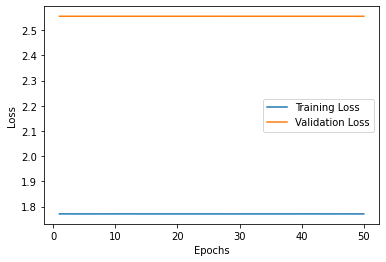

In [ ]:
loss_values = lstm_history.history['loss']
val_loss_values = lstm_history.history['val_loss']
epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, label='Training Loss')
plt.plot(epochs, val_loss_values, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Gated recurrent unit

## Transformers: Attention is all you need!

In [48]:
from tensorflow.keras.layers import Conv1D, Dropout, MaxPool1D, Dense, Embedding, Attention
from tensorflow.keras.regularizers import *
from keras.models import *
from keras.layers.core import *
from keras.layers import merge
import tensorflow_addons as tfa

In [47]:
pip install tensorflow-addons

     |████████████████████████████████| 1.1 MB 37.9 MB/s eta 0:00:01


In [49]:
X_train_window_size_5 = X_train_window_size_5.drop(['total_hours', 'minutes_4_3', 'minutes_3_2', 'minutes_2_1', 'dlvry_weekend', 'volume_4_3','volume_3_2', 'volume_2_1'], axis=1)
X_valid_window_size_5 = X_valid_window_size_5.drop(['total_hours', 'minutes_4_3', 'minutes_3_2', 'minutes_2_1', 'dlvry_weekend', 'volume_4_3','volume_3_2', 'volume_2_1'], axis=1)
X_test_window_size_5 = X_test_window_size_5.drop(['total_hours', 'minutes_4_3', 'minutes_3_2', 'minutes_2_1', 'dlvry_weekend', 'volume_4_3','volume_3_2', 'volume_2_1'], axis=1)

In [57]:
EPOCHS = 10
BATCH_SIZE = 64
DENSE_LAYER_SIZE = 256
DROP_OUT = 0.5

def Self_Attention_Dense():

    clear_session
    
    #inputs = Input(shape=(X_train.shape[1],))
    q_input = Input(shape=(X_train_window_size_5.shape[1],))

    #Dense Layer for Embedding
    D_EM_q = Dense(X_train_window_size_5.shape[1], activation='softmax', 
                   kernel_initializer=k.initializers.HeNormal)(q_input)

    # Self Attention
    qv_attention_seq = tf.keras.layers.Attention()(
       [q_input, D_EM_q])

    # Concatenate input and Self Attention object to produce input layer
    Atten_inputs = merge.Concatenate()(
        [q_input, qv_attention_seq])

    #1 Dense Layer
    Dense_1 = Dense(DENSE_LAYER_SIZE, name='Dense_1', activation='relu', 
                    kernel_initializer=k.initializers.HeNormal)(Atten_inputs)

    #Dropout
    Dropout_1 = Dropout(DROP_OUT)(Dense_1)
    #2 Dense Layer
    Dense_2 = Dense(DENSE_LAYER_SIZE, name='Dense_2', activation='relu', 
                    kernel_initializer=k.initializers.HeNormal)(Dropout_1)
    #Dropout
    Dropout_2 = Dropout(DROP_OUT)(Dense_2)
    #Output
    output = Dense(1, name='output_layer', activation='linear')(Dropout_2)

    model = Model(inputs=[q_input], outputs=output)

    radam = tfa.optimizers.RectifiedAdam()
    ranger = tfa.optimizers.Lookahead(radam, sync_period=6, slow_step_size=0.5)
    
    model.compile(optimizer=ranger, loss='mae')

    model_history = model.fit(X_train_window_size_5, y_train_window_size_5, validation_data=(X_valid_window_size_5, y_valid_window_size_5), epochs=EPOCHS, batch_size=BATCH_SIZE, shuffle=True)

    return model, model_history

In [58]:
model, model_history = Self_Attention_Dense()

Epoch 1/10
1430/1430 [==============================] - 11s 6ms/step - loss: 1.8559 - val_loss: 2.5549
Epoch 2/10
1430/1430 [==============================] - 8s 6ms/step - loss: 1.7801 - val_loss: 2.5556
Epoch 3/10
1430/1430 [==============================] - 8s 6ms/step - loss: 1.7731 - val_loss: 2.5551
Epoch 4/10
1430/1430 [==============================] - 8s 6ms/step - loss: 1.7716 - val_loss: 2.5549
Epoch 5/10
1430/1430 [==============================] - 8s 6ms/step - loss: 1.7708 - val_loss: 2.5544
Epoch 6/10
1430/1430 [==============================] - 8s 6ms/step - loss: 1.7706 - val_loss: 2.5543
Epoch 7/10
1430/1430 [==============================] - 8s 6ms/step - loss: 1.7702 - val_loss: 2.5530
Epoch 8/10
1430/1430 [==============================] - 8s 6ms/step - loss: 1.7705 - val_loss: 2.5538
Epoch 9/10
1430/1430 [==============================] - 8s 6ms/step - loss: 1.7703 - val_loss: 2.5538
Epoch 10/10
1430/1430 [==============================] - 8s 6ms/step - loss: 1.76

In [59]:
evaluate_model(model, X_test_window_size_5, y_test_window_size_5)

Mean absolut error on test: 2.2565478619431096


2.2565478619431096

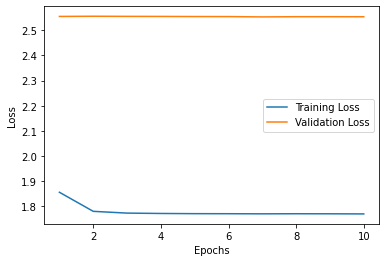

In [60]:
loss_values = model_history.history['loss']
val_loss_values = model_history.history['val_loss']
epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, label='Training Loss')
plt.plot(epochs, val_loss_values, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()